## Data Exploration
## Content
  * Load data 
  * Remove bad fields
  * Dealing with missing data
  * Correlation matrix for numerical features
  * Encode categorical features to numerical
  * Correlation matrix for encoded categorical features
  * Investigate Logarifm transformations
  * Investigate Pow transformations

In [1]:
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy import stats
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
from pymongo import MongoClient
import warnings
import sklearn.linear_model as linear_model
%matplotlib inline

warnings.filterwarnings('ignore')

In [2]:
MONGODB_URL = os.environ['MONGODB_URI']
client = MongoClient(MONGODB_URL)
db = client.get_default_database()

In [3]:
data = db["train_data"].find({})
df_train = pd.DataFrame(list(data))
df_train.drop(columns=["_id"], inplace=True)
df_train.shape

(1460, 79)

In [4]:
data = db["test_data"].find({})
df_test = pd.DataFrame(list(data))
df_test.drop(columns=["_id"], inplace=True)
df_test.shape

(1468, 79)

In [5]:
full_frame = pd.concat([df_train, df_test])
full_frame.reset_index(drop=True, inplace=True)
full_frame.shape

(2928, 79)

In [6]:
full_frame.isnull().sum().max() #just checking that there's no missing data missing...

0

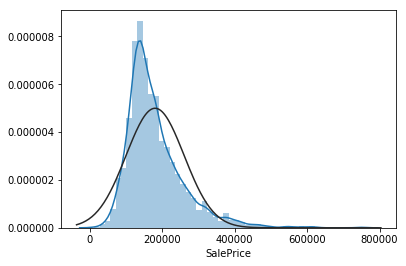

In [7]:
#histogram
sns.distplot(full_frame['SalePrice'], fit=norm);

### Remove bad fields

In [8]:
features = set(full_frame.columns.tolist())
features.remove('OverallQual')
features.remove('KitchenQual')
features.remove('HeatingQC')
features.remove('ExterQual')
features = list(features)

In [9]:
len(features)

75

### Lists of numerical and categorical features

In [10]:
# get categorical features list
g = {k.name: v for k, v in full_frame[features].columns.to_series().groupby(full_frame[features].dtypes).groups.items()}
categorical = g["object"].tolist()
numerical = g["float64"].tolist() + g["int64"].tolist()
g

{'float64': Index(['GarageArea', 'GarageCars', 'BsmtHalfBath', 'BsmtUnfSF', 'BsmtFinSF2',
        'MasVnrArea', 'BsmtFullBath', 'LotFrontage', 'BsmtFinSF1',
        'TotalBsmtSF'],
       dtype='object'),
 'int64': Index(['EnclosedPorch', 'FullBath', '1stFlrSF', 'MiscVal', 'Fireplaces',
        'PoolArea', 'OpenPorchSF', 'GrLivArea', 'OverallCond', 'TotRmsAbvGrd',
        'HalfBath', 'WoodDeckSF', 'KitchenAbvGr', 'YearBuilt', 'LotArea',
        'ScreenPorch', 'YearRemodAdd', 'YrSold', '2ndFlrSF', 'LowQualFinSF',
        '3SsnPorch', 'SalePrice', 'BedroomAbvGr'],
       dtype='object'),
 'object': Index(['BsmtQual', 'PoolQC', 'Utilities', 'Functional', 'BsmtFinType1',
        'LotConfig', 'BsmtExposure', 'Street', 'Fence', 'Exterior2nd',
        'Neighborhood', 'LotShape', 'FireplaceQu', 'CentralAir', 'MSZoning',
        'Condition2', 'MasVnrType', 'BldgType', 'BsmtFinType2', 'Exterior1st',
        'MSSubClass', 'MiscFeature', 'GarageFinish', 'GarageQual', 'Heating',
        'MoSold', '

### Correlation matrix for numerical features

In [11]:
# numerical features list
numerical

['GarageArea',
 'GarageCars',
 'BsmtHalfBath',
 'BsmtUnfSF',
 'BsmtFinSF2',
 'MasVnrArea',
 'BsmtFullBath',
 'LotFrontage',
 'BsmtFinSF1',
 'TotalBsmtSF',
 'EnclosedPorch',
 'FullBath',
 '1stFlrSF',
 'MiscVal',
 'Fireplaces',
 'PoolArea',
 'OpenPorchSF',
 'GrLivArea',
 'OverallCond',
 'TotRmsAbvGrd',
 'HalfBath',
 'WoodDeckSF',
 'KitchenAbvGr',
 'YearBuilt',
 'LotArea',
 'ScreenPorch',
 'YearRemodAdd',
 'YrSold',
 '2ndFlrSF',
 'LowQualFinSF',
 '3SsnPorch',
 'SalePrice',
 'BedroomAbvGr']

In [12]:
len(numerical)

33

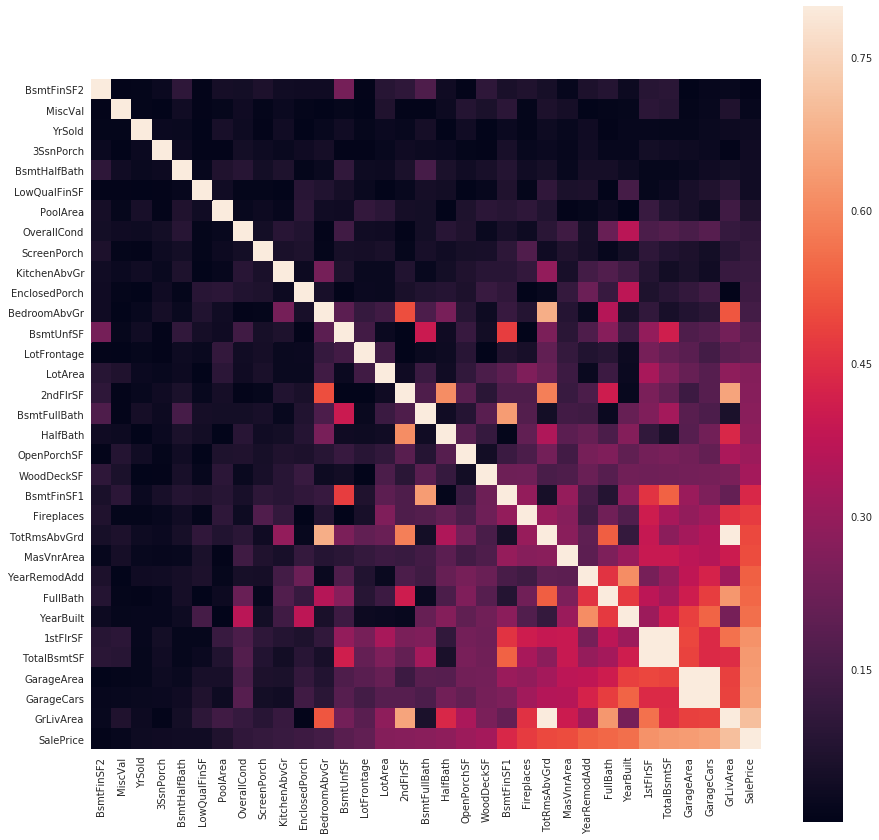

In [13]:
numerical_df = full_frame[numerical]

#correlation matrix
corrmat = numerical_df.corr().abs()
# sort columns in df by SalePrice correlation
cols = corrmat.sort_values(["SalePrice"])['SalePrice'].index
# get new correlation matrix with sorted columns
cm = numerical_df[cols].corr().abs()
# show plot
sns.set(rc={'figure.figsize':(15,15)})
sns.heatmap(cm, vmax=.8, square=True, yticklabels=cols.values, xticklabels=cols.values)

In [14]:
# dealing with features which highly correlated with each other

# features which correlated with each other more then this threshold should be considered to remove
thresh = 0.7

# mask to go through only under diagonal triangle
mask = np.ones(cm.shape,dtype='bool')
mask[np.triu_indices(len(cm))] = False

highly_corr_cm = cm.drop(index=['SalePrice'],columns=['SalePrice'])[(cm>thresh)&mask].dropna(axis=0, how='all').dropna(axis=1, how='all')
highly_corr_cm = highly_corr_cm.append(cm['SalePrice'][highly_corr_cm.columns])
highly_corr_cm['SalePrice'] = cm['SalePrice'][highly_corr_cm.index]
highly_corr_cm

,TotRmsAbvGrd,1stFlrSF,GarageArea,SalePrice
TotalBsmtSF,NaN,0.800645,NaN,0.632445
GarageCars,NaN,NaN,0.889901,0.647446
GrLivArea,0.807717,NaN,NaN,0.706625
SalePrice,0.495173,0.621661,0.640010,1.000000


In [15]:
columns_to_remove = [
    "1stFlrSF",
    "GarageArea",
    "TotRmsAbvGrd"]

In [16]:
numerical_df.drop(columns=columns_to_remove, inplace=True)

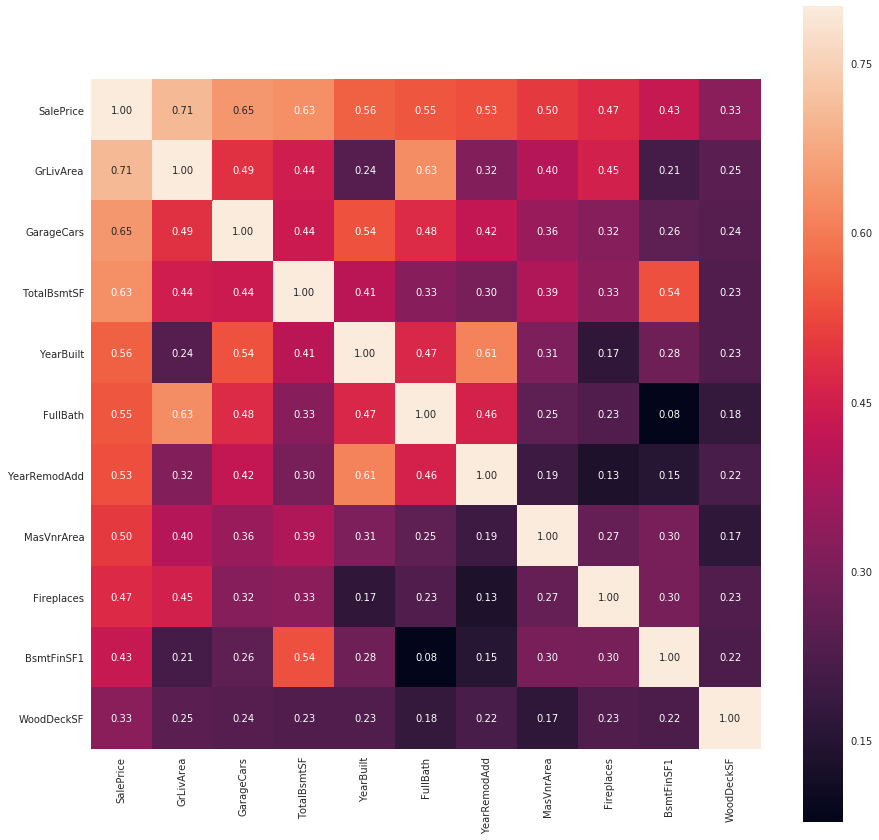

In [17]:
#saleprice correlation matrix
corrmat = numerical_df.corr().abs()
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k+1, 'SalePrice')['SalePrice'].index
cm = numerical_df[cols].corr().abs()
sns.set(rc={'figure.figsize':(15,15)})
sns.heatmap(cm, vmax=.8, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)

In [18]:
selected_numerical_features = cols.drop('SalePrice').tolist()
selected_numerical_features

['GrLivArea',
 'GarageCars',
 'TotalBsmtSF',
 'YearBuilt',
 'FullBath',
 'YearRemodAdd',
 'MasVnrArea',
 'Fireplaces',
 'BsmtFinSF1',
 'WoodDeckSF']

### Encode categorical features to numerical

In [19]:
# categorical features list
categorical

['BsmtQual',
 'PoolQC',
 'Utilities',
 'Functional',
 'BsmtFinType1',
 'LotConfig',
 'BsmtExposure',
 'Street',
 'Fence',
 'Exterior2nd',
 'Neighborhood',
 'LotShape',
 'FireplaceQu',
 'CentralAir',
 'MSZoning',
 'Condition2',
 'MasVnrType',
 'BldgType',
 'BsmtFinType2',
 'Exterior1st',
 'MSSubClass',
 'MiscFeature',
 'GarageFinish',
 'GarageQual',
 'Heating',
 'MoSold',
 'ExterCond',
 'RoofMatl',
 'PavedDrive',
 'SaleType',
 'HouseStyle',
 'BsmtCond',
 'RoofStyle',
 'LandContour',
 'Foundation',
 'GarageCond',
 'Condition1',
 'GarageType',
 'LandSlope',
 'Alley',
 'Electrical',
 'SaleCondition']

In [20]:
len(categorical)

42

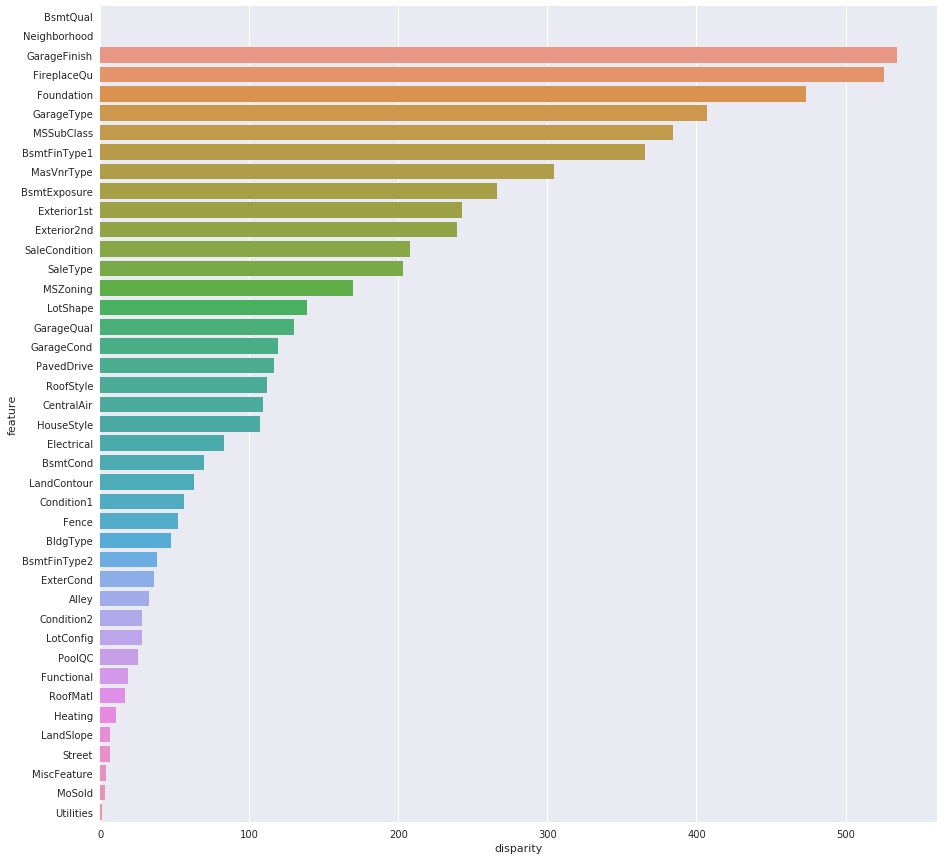

In [21]:
# perform ANOVA test 

def anova(frame, qualitative):
    anv = pd.DataFrame()
    anv['feature'] = qualitative
    pvals = []
    for c in qualitative:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c] == cls]['SalePrice'].values
            samples.append(s.astype(np.float64))
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

a = anova(full_frame.copy(True), categorical)
a['disparity'] = np.log(1./a['pval'].values)
sns.set(rc={'figure.figsize':(15,15)})
sns.barplot(data=a, y='feature', x='disparity')

In [22]:
# perform encoding

dummies = {}

def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature] = o
    
    return ordering
    
for c in categorical:  
    dummies[c] = encode(full_frame, c)

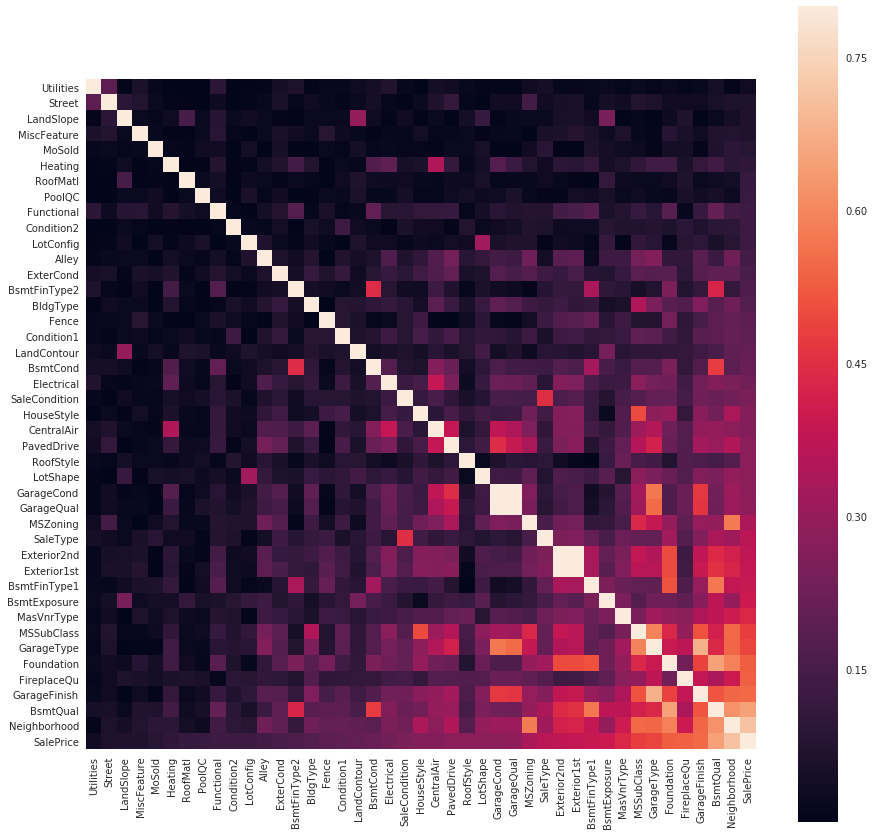

In [23]:
categorical_df = full_frame[categorical + ['SalePrice']]

#correlation matrix
corrmat = categorical_df.corr().abs()
cols = corrmat.sort_values(["SalePrice"])['SalePrice'].index
cm = categorical_df[cols].corr().abs()
sns.set(rc={'figure.figsize':(15,15)})
sns.heatmap(cm, vmax=.8, square=True, yticklabels=cols.values, xticklabels=cols.values)

In [24]:
mask = np.ones(cm.shape,dtype='bool')
mask[np.triu_indices(len(cm))] = False

In [25]:
thresh = 0.7
highly_corr_cm = cm.drop(index=['SalePrice'],columns=['SalePrice'])[(cm>thresh)&mask].dropna(axis=0, how='all').dropna(axis=1, how='all')
highly_corr_cm = highly_corr_cm.append(cm['SalePrice'][highly_corr_cm.columns])
highly_corr_cm['SalePrice'] = cm['SalePrice'][highly_corr_cm.index]
highly_corr_cm

,GarageCond,Exterior2nd,SalePrice
GarageQual,0.832726,NaN,0.288649
Exterior1st,NaN,0.871410,0.382388
SalePrice,0.281926,0.375923,1.000000


In [26]:
columns_to_remove = ["Exterior2nd", "GarageCond"]

In [27]:
categorical_df.drop(columns=columns_to_remove, inplace=True)

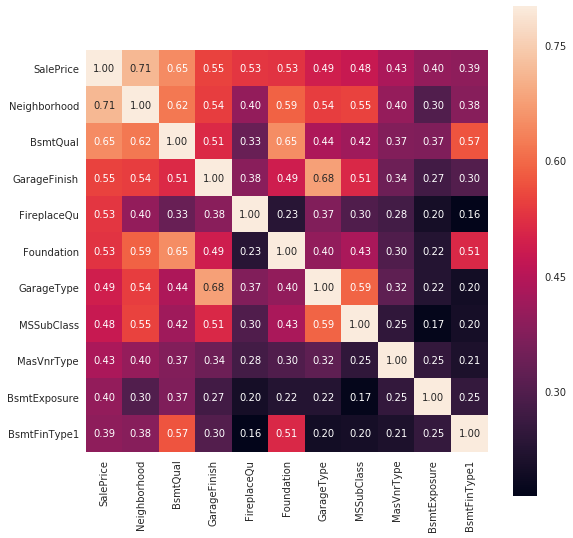

In [28]:
#saleprice correlation matrix
corrmat = categorical_df.corr().abs()
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k+1, 'SalePrice')['SalePrice'].index
cm = categorical_df[cols].corr().abs()
sns.set(rc={'figure.figsize':(9,9)})
sns.heatmap(cm, vmax=.8, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)

In [29]:
selected_categorical_features = cols.drop('SalePrice').tolist()
selected_categorical_features

['Neighborhood',
 'BsmtQual',
 'GarageFinish',
 'FireplaceQu',
 'Foundation',
 'GarageType',
 'MSSubClass',
 'MasVnrType',
 'BsmtExposure',
 'BsmtFinType1']

### Summarize

In [30]:
features = selected_categorical_features + selected_numerical_features
features

['Neighborhood',
 'BsmtQual',
 'GarageFinish',
 'FireplaceQu',
 'Foundation',
 'GarageType',
 'MSSubClass',
 'MasVnrType',
 'BsmtExposure',
 'BsmtFinType1',
 'GrLivArea',
 'GarageCars',
 'TotalBsmtSF',
 'YearBuilt',
 'FullBath',
 'YearRemodAdd',
 'MasVnrArea',
 'Fireplaces',
 'BsmtFinSF1',
 'WoodDeckSF']

### Logarifm transformations

In [31]:
logarifm_frame = full_frame[features + ['SalePrice']].copy(True)
for feature in logarifm_frame.columns:
    logarifm_frame[feature] = logarifm_frame[feature].apply(lambda row: 0 if row in (0,1) else np.log(row))

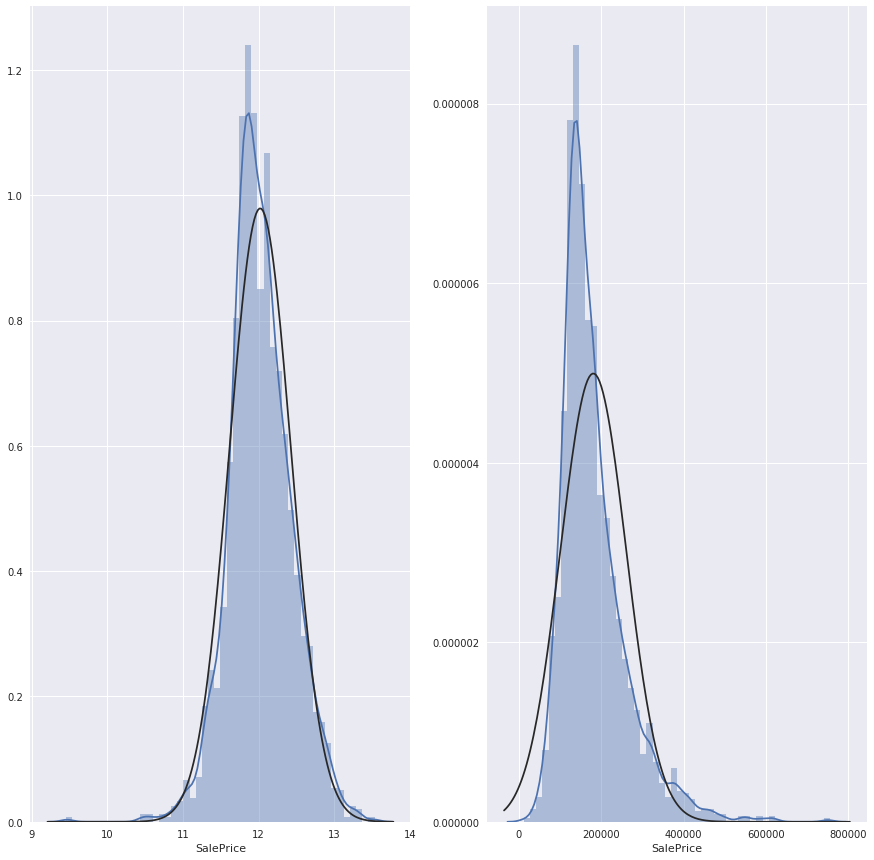

In [32]:
#histogram
sns.set(rc={'figure.figsize':(15,15)})
fig, ax =plt.subplots(1,2)
sns.distplot(logarifm_frame['SalePrice'], fit=norm, ax=ax[0])
sns.distplot(full_frame['SalePrice'], fit=norm, ax=ax[1])
fig.show()

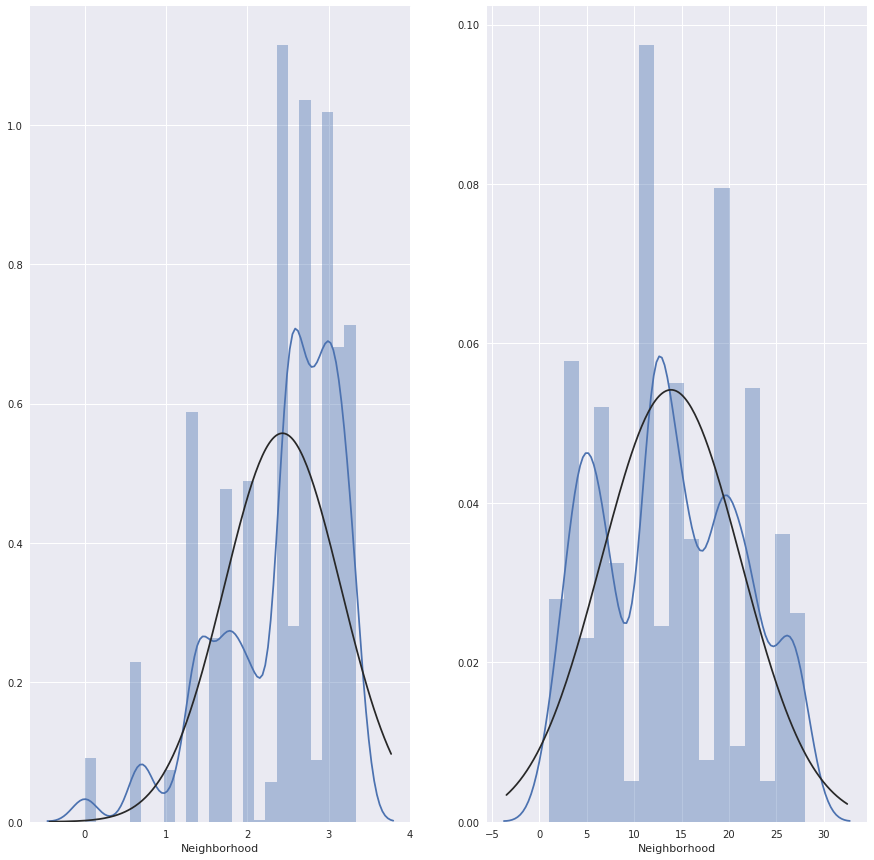

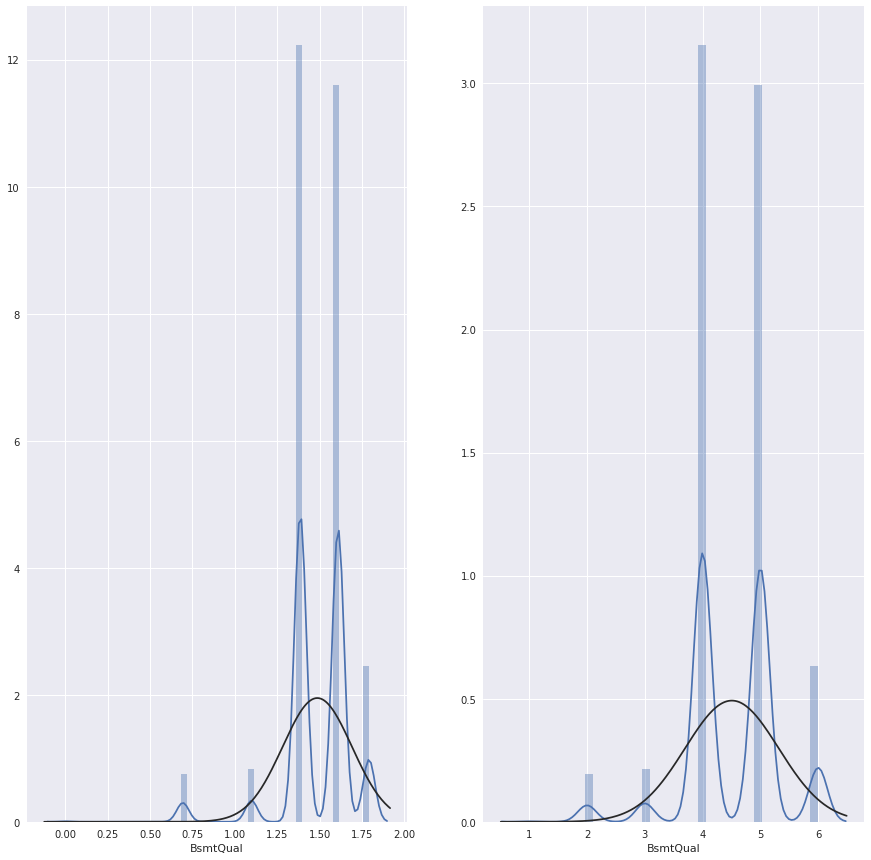

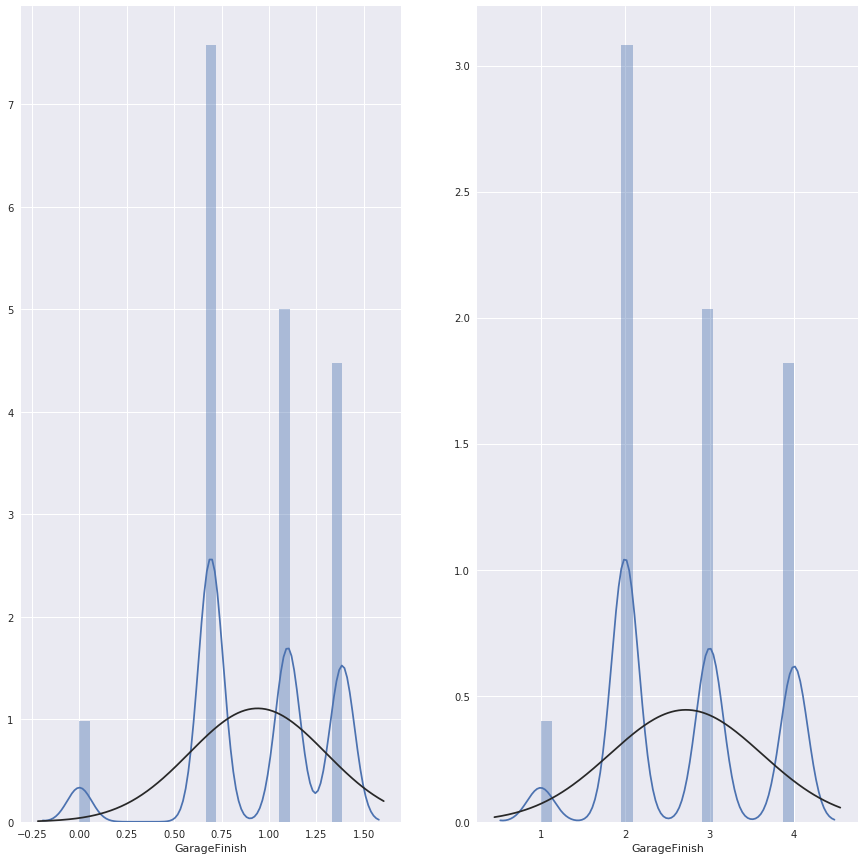

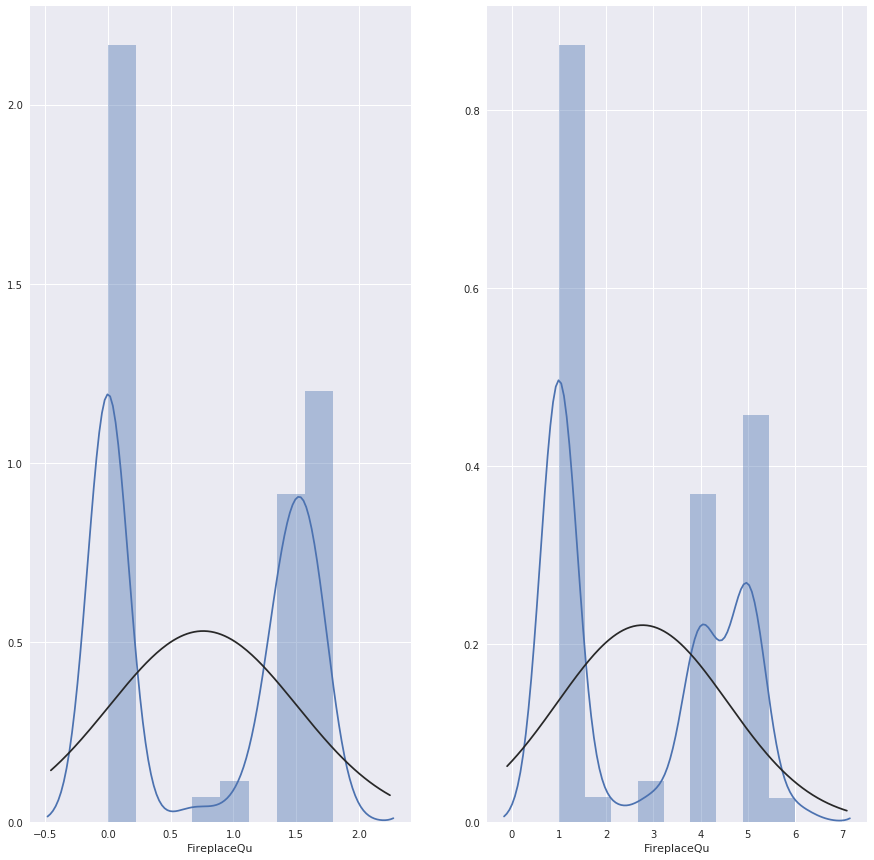

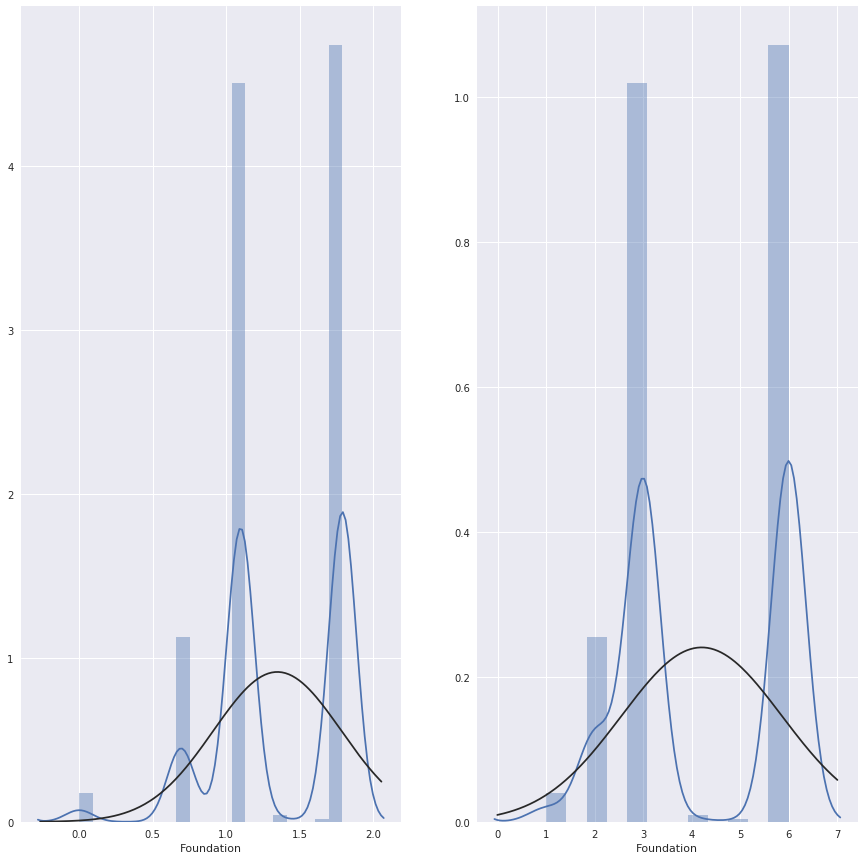

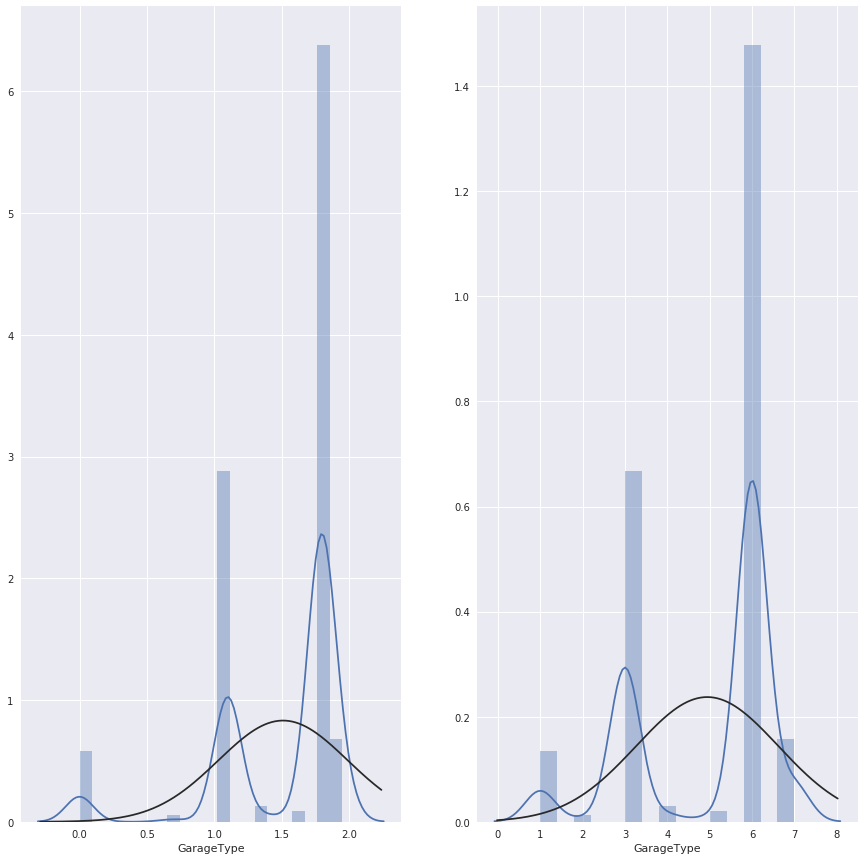

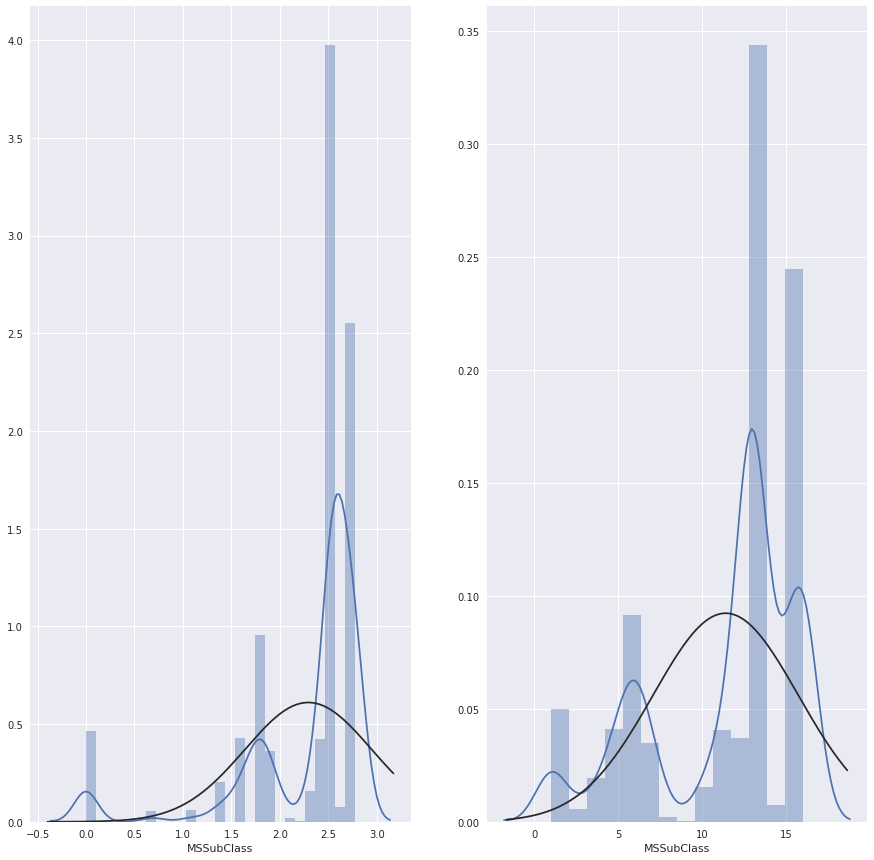

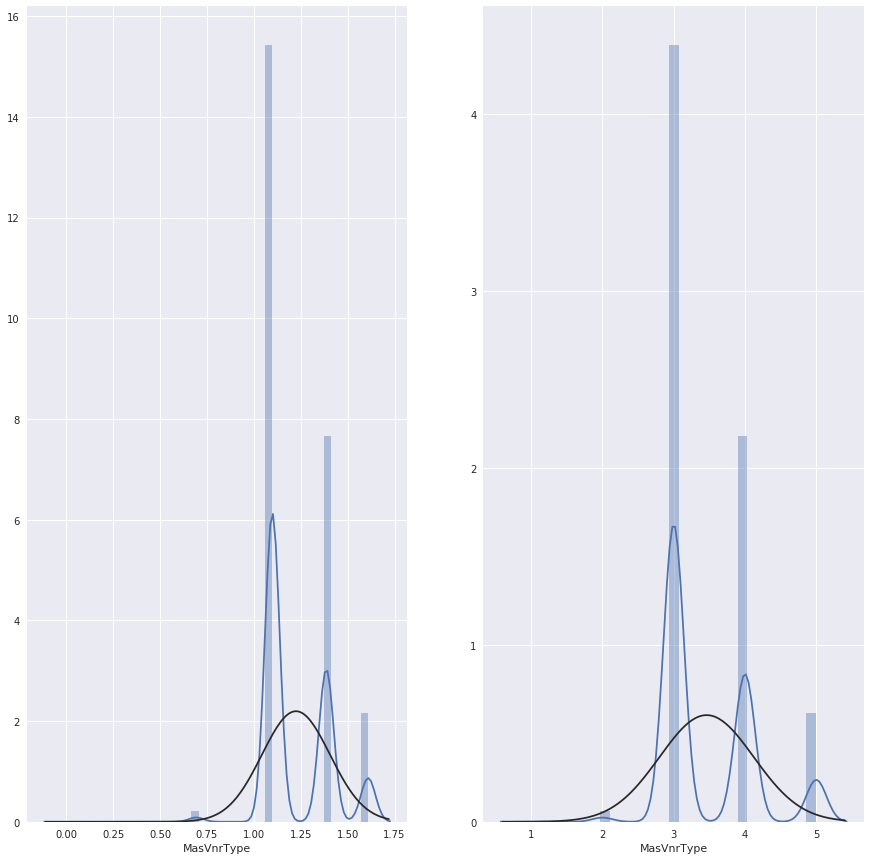

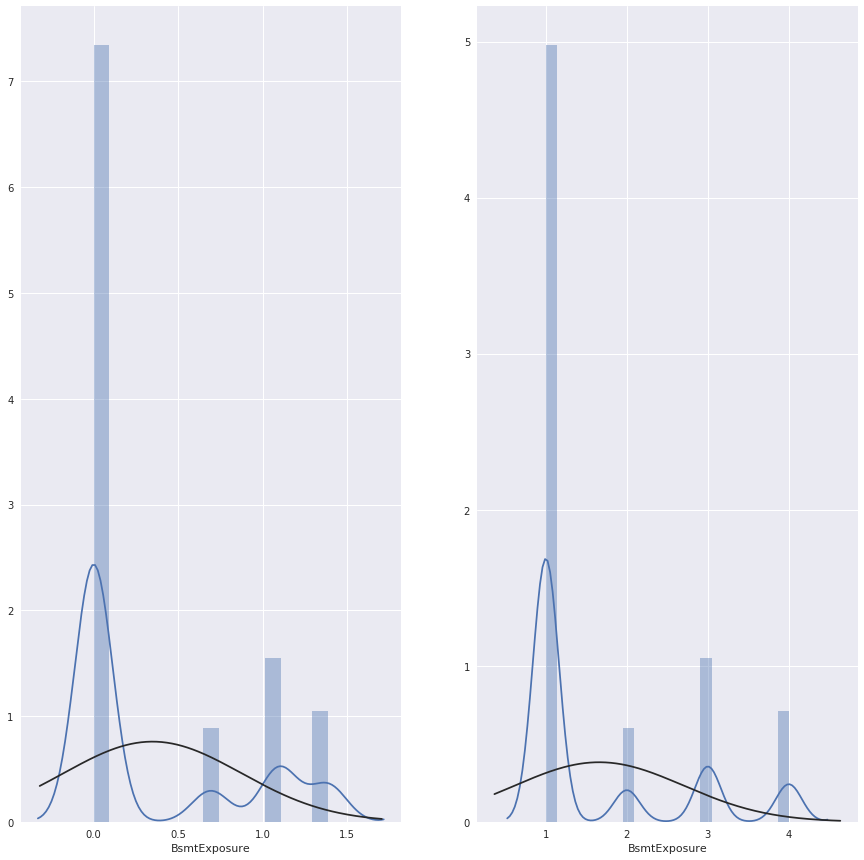

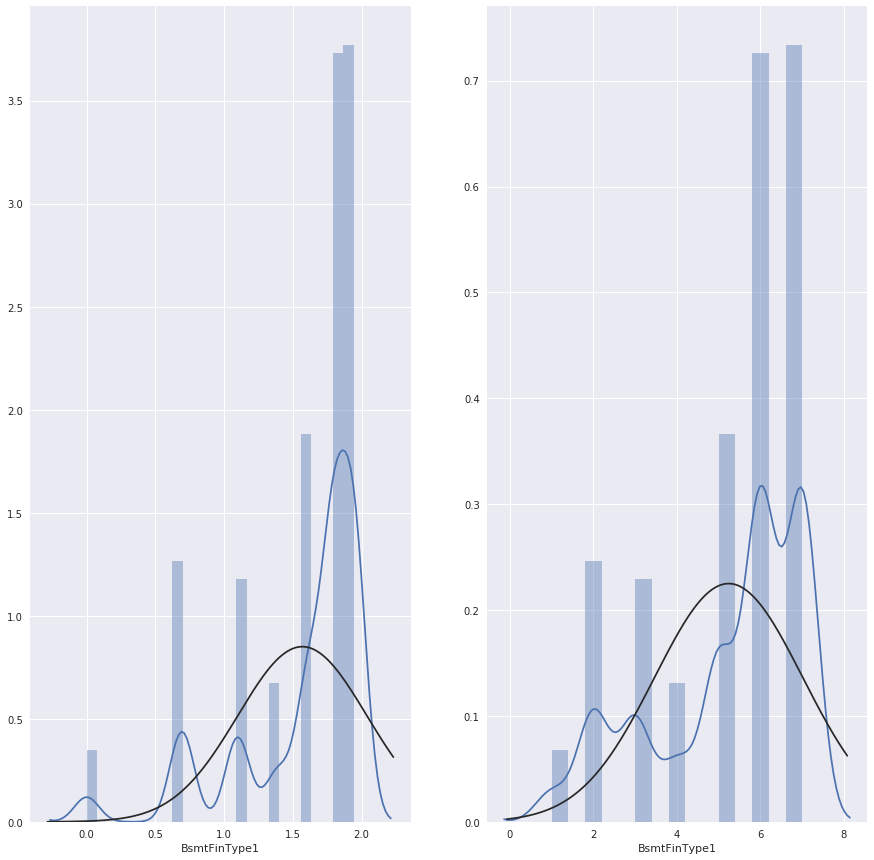

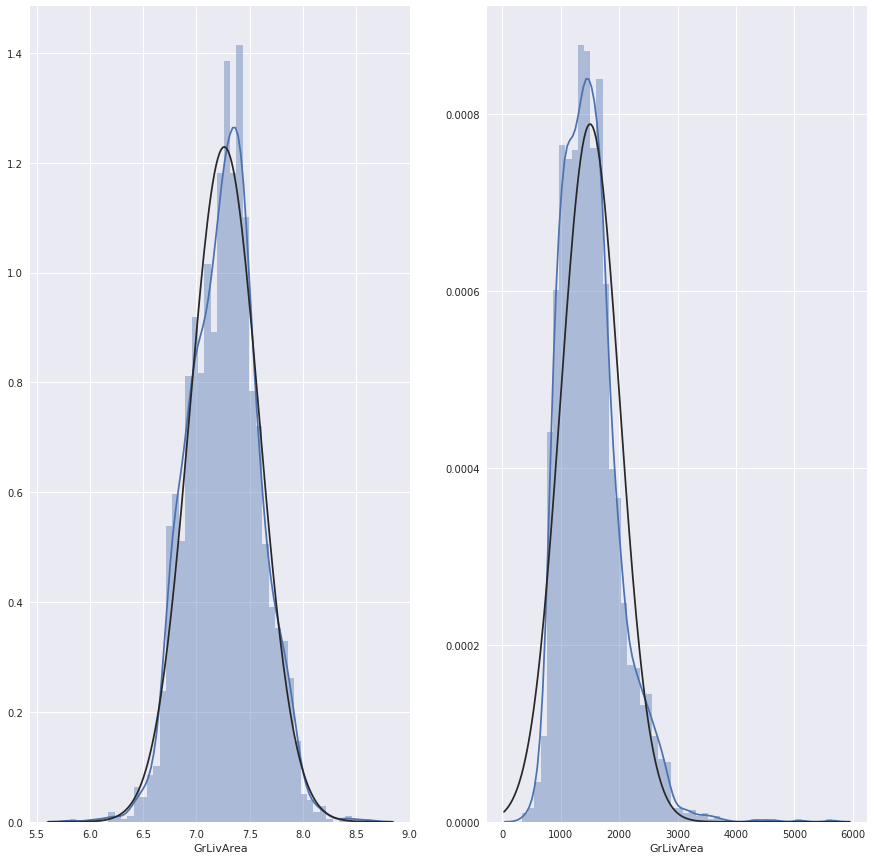

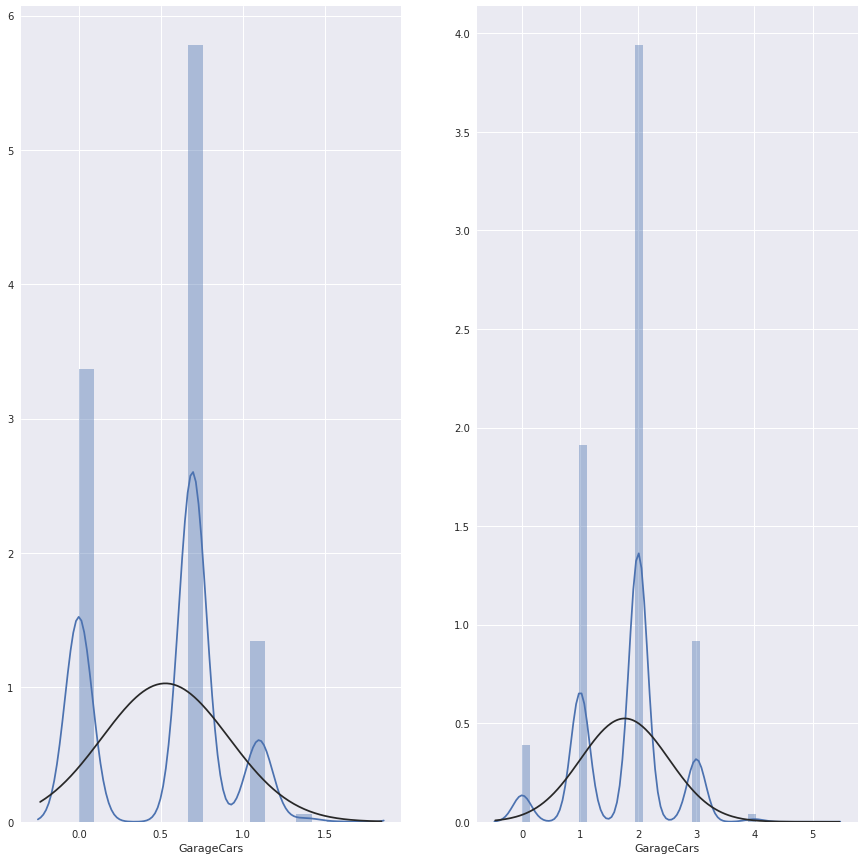

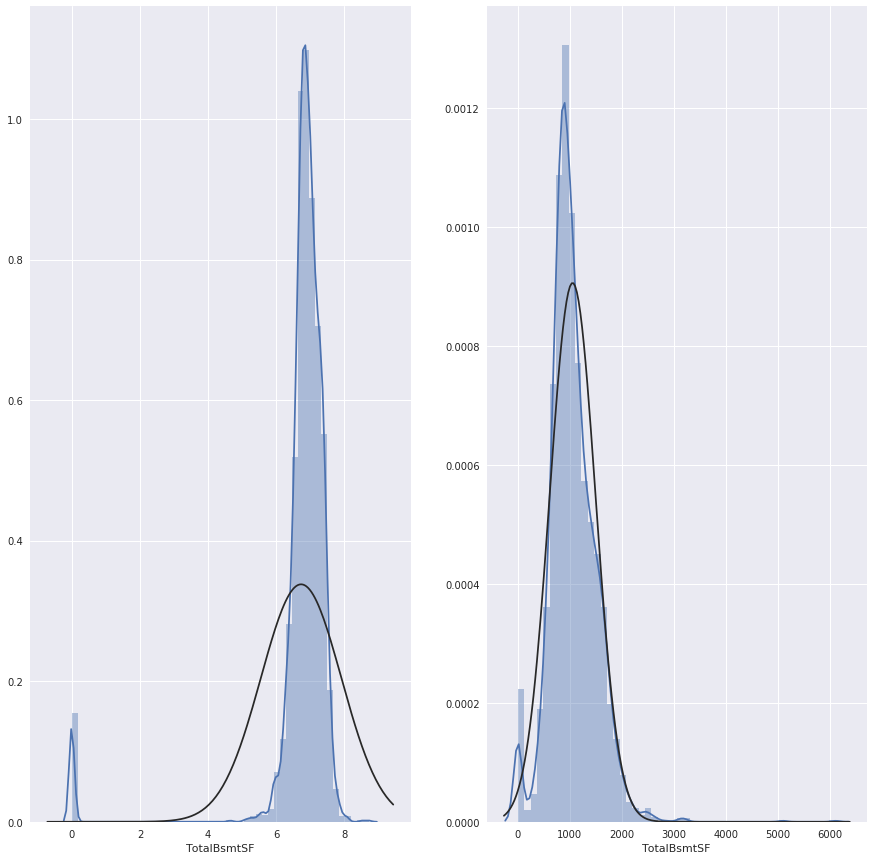

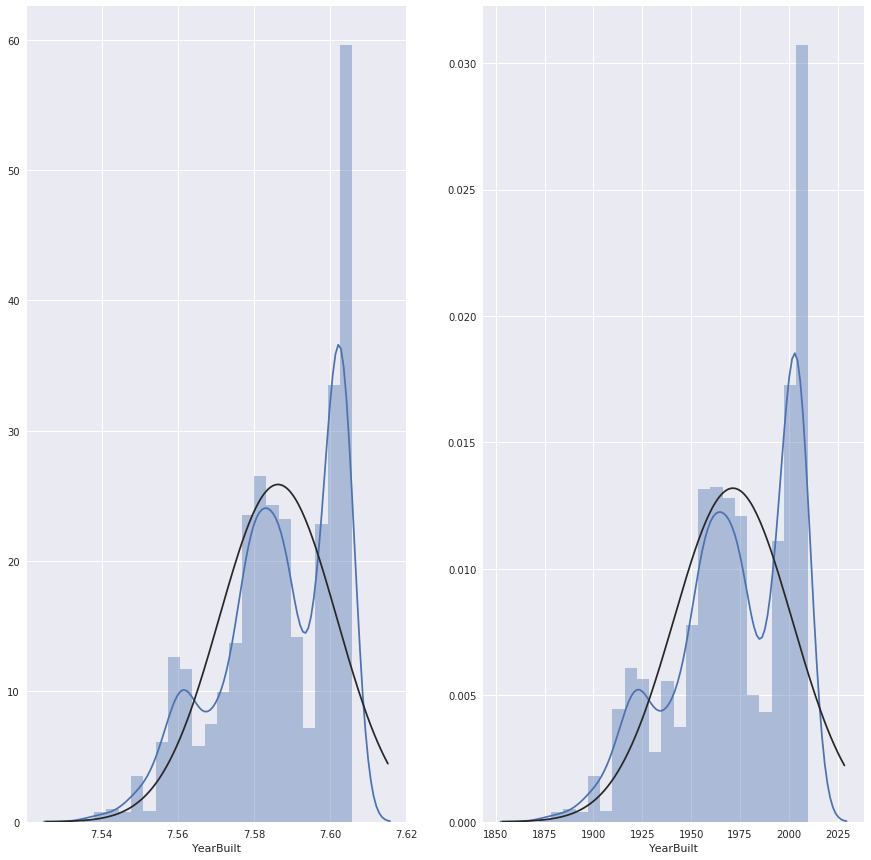

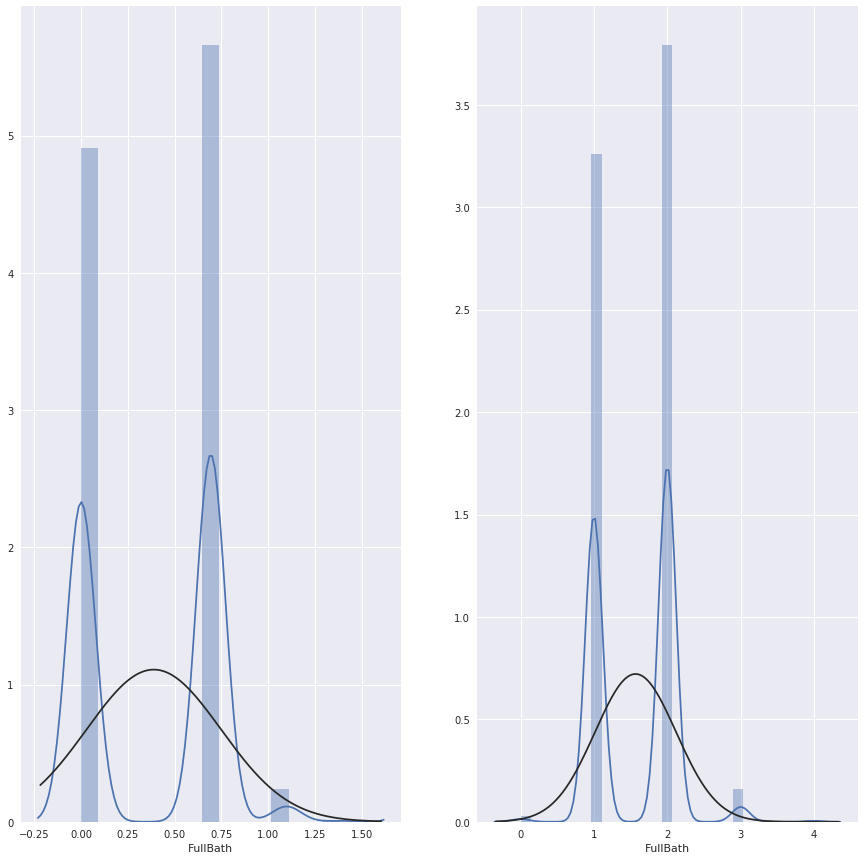

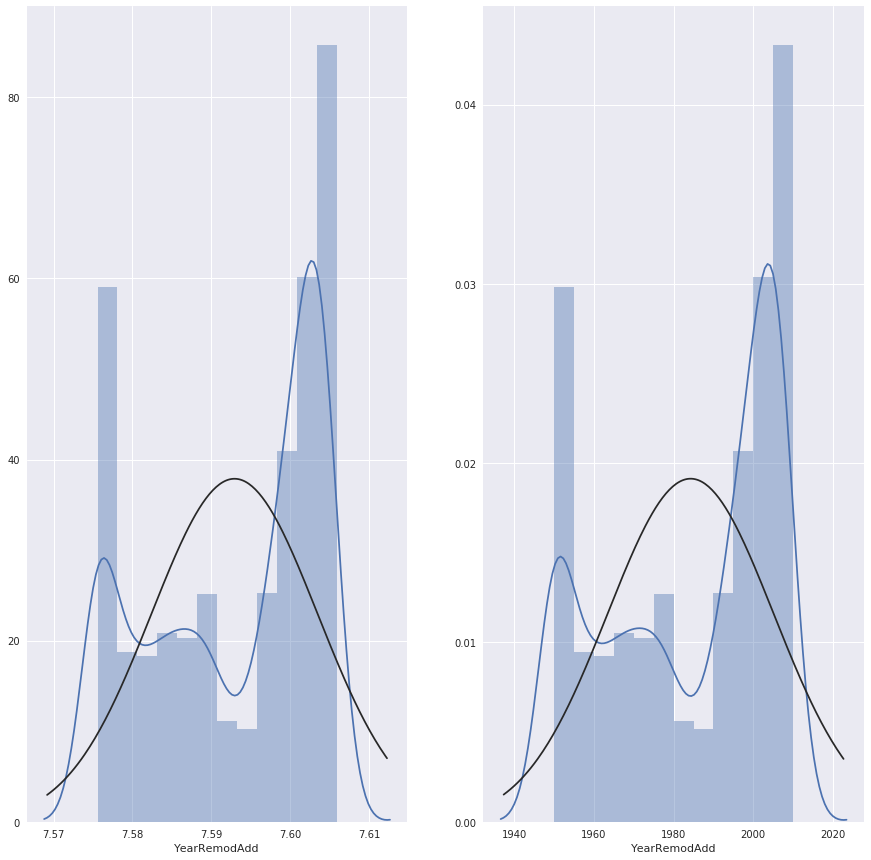

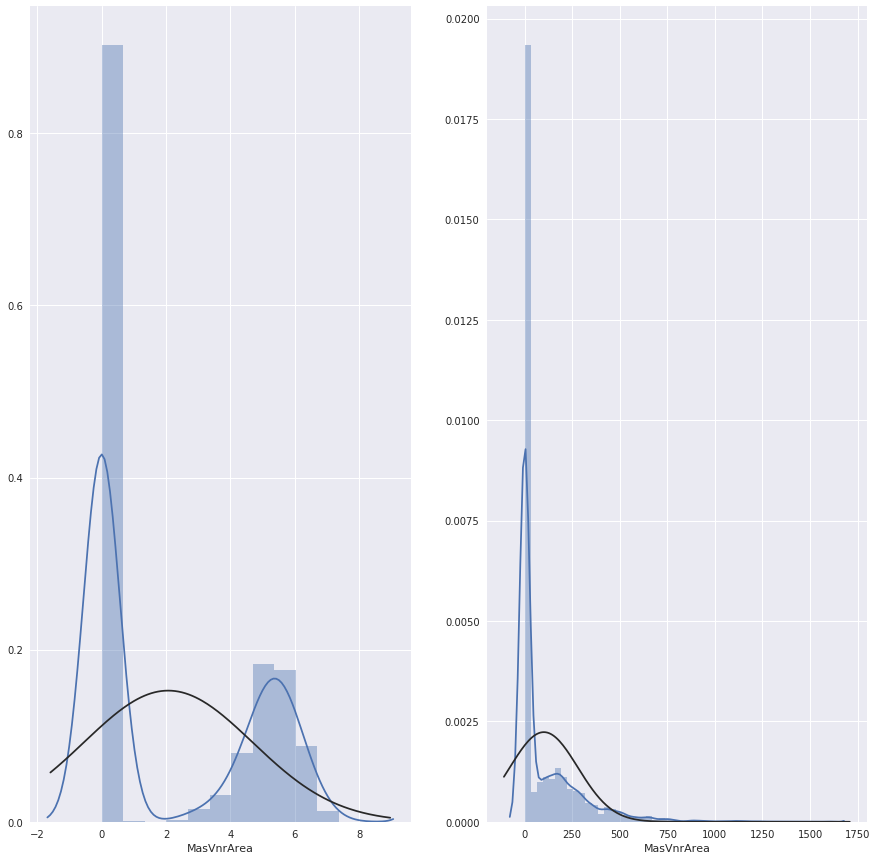

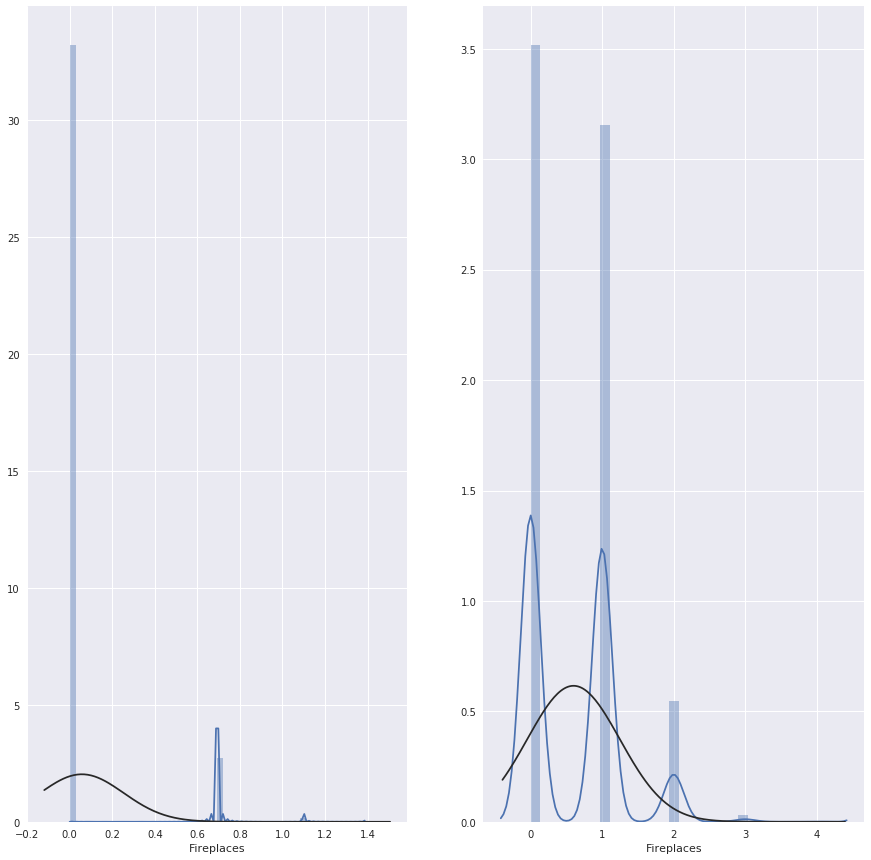

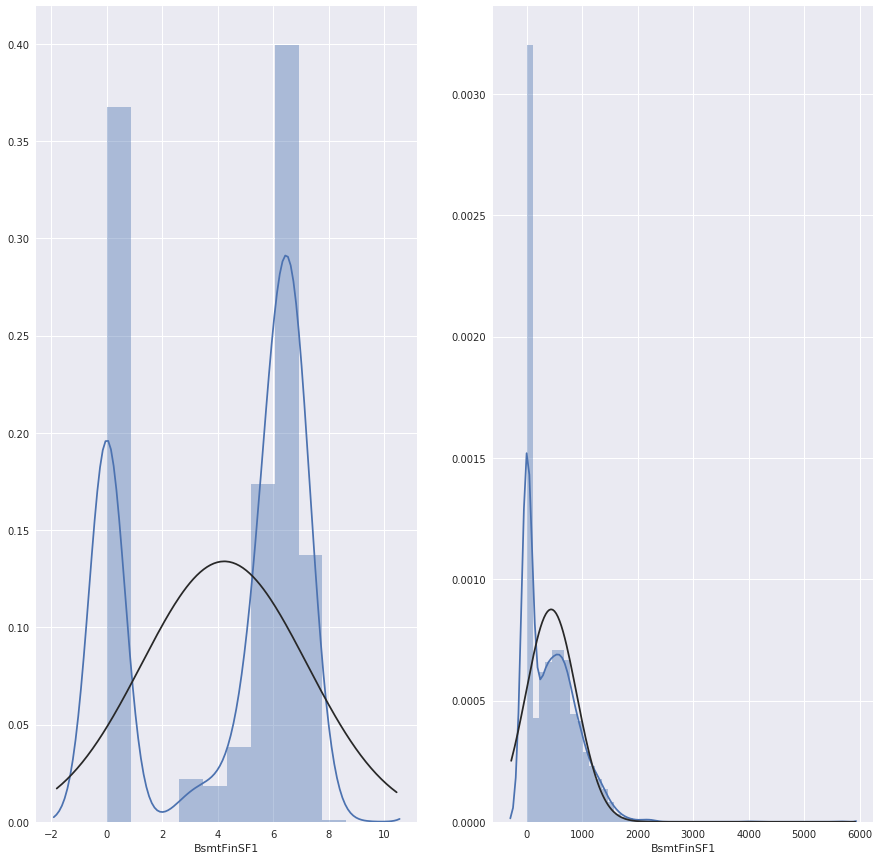

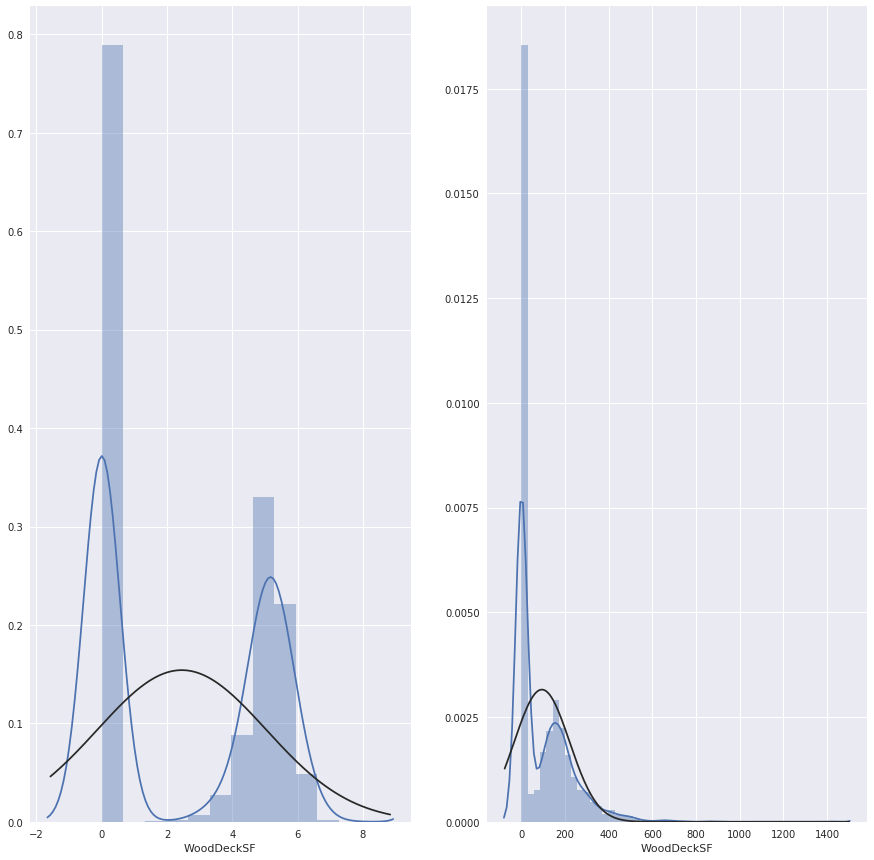

In [33]:
for feature in features:
    plt.figure()
    fig, ax =plt.subplots(1,2)
    sns.set(rc={'figure.figsize':(15,15)})
    sns.distplot(logarifm_frame[feature], fit=norm, ax=ax[0]);
    sns.distplot(full_frame[feature], fit=norm, ax=ax[1]);

### Pow transformations

In [34]:
pow_frame = full_frame[features + ['SalePrice']].copy(True)
for feature in logarifm_frame.columns:
    pow_frame[feature] = pow_frame[feature].apply(lambda row: row**2)

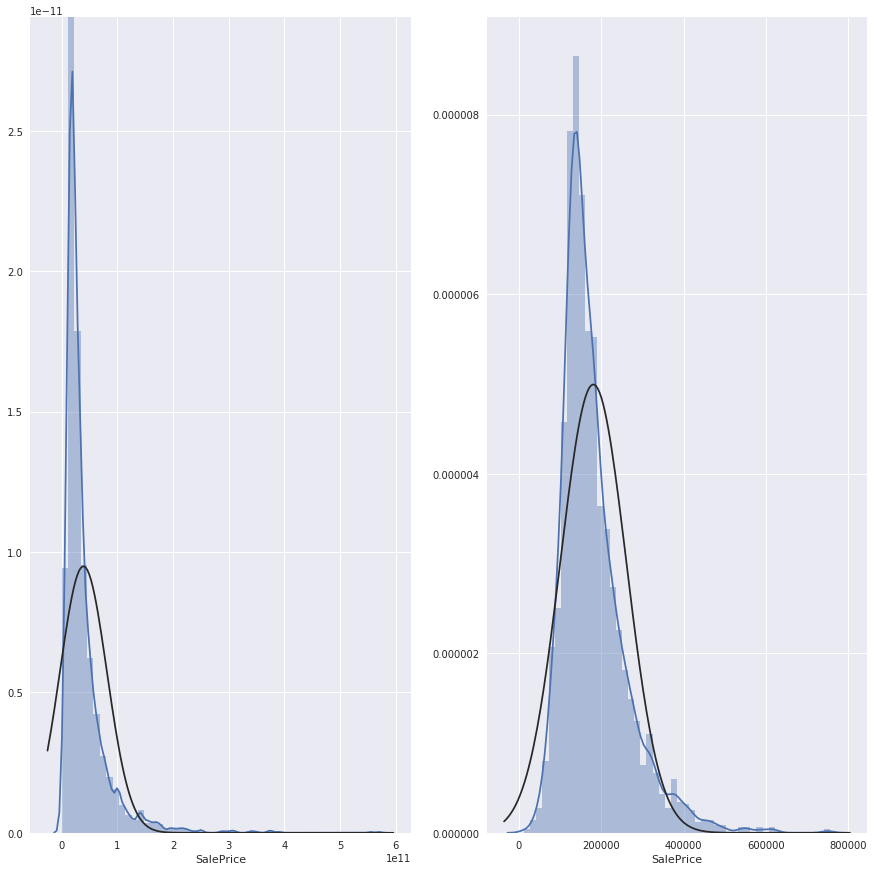

In [35]:
#histogram
sns.set(rc={'figure.figsize':(15,15)})
fig, ax =plt.subplots(1,2)
sns.distplot(pow_frame['SalePrice'], fit=norm, ax=ax[0])
sns.distplot(full_frame['SalePrice'], fit=norm, ax=ax[1])
fig.show()

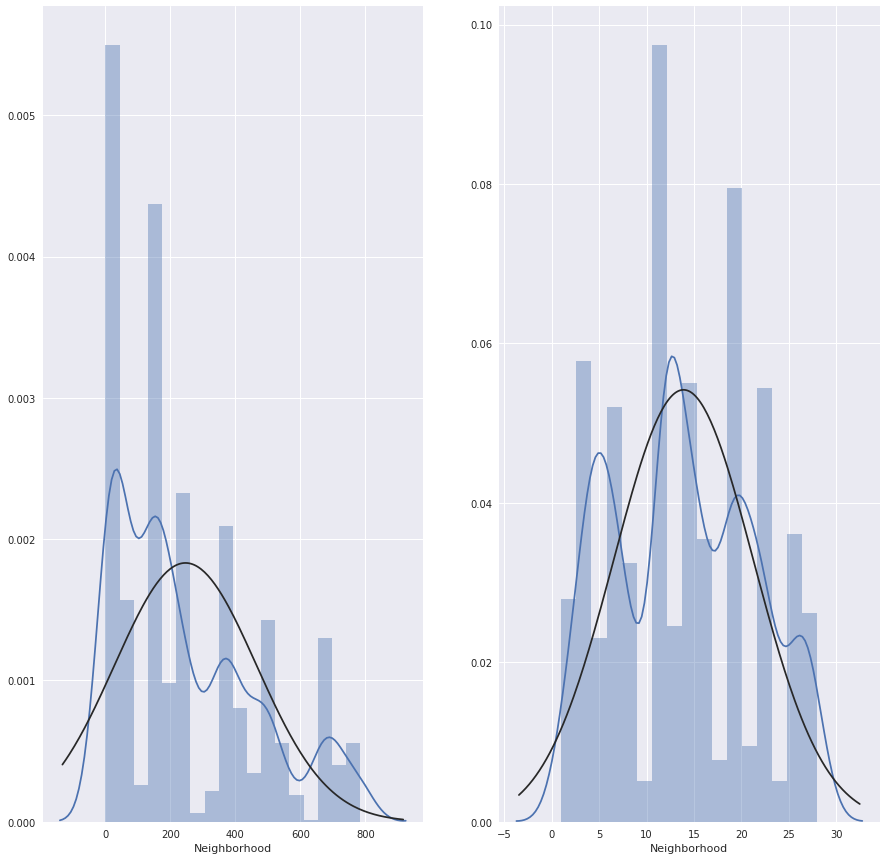

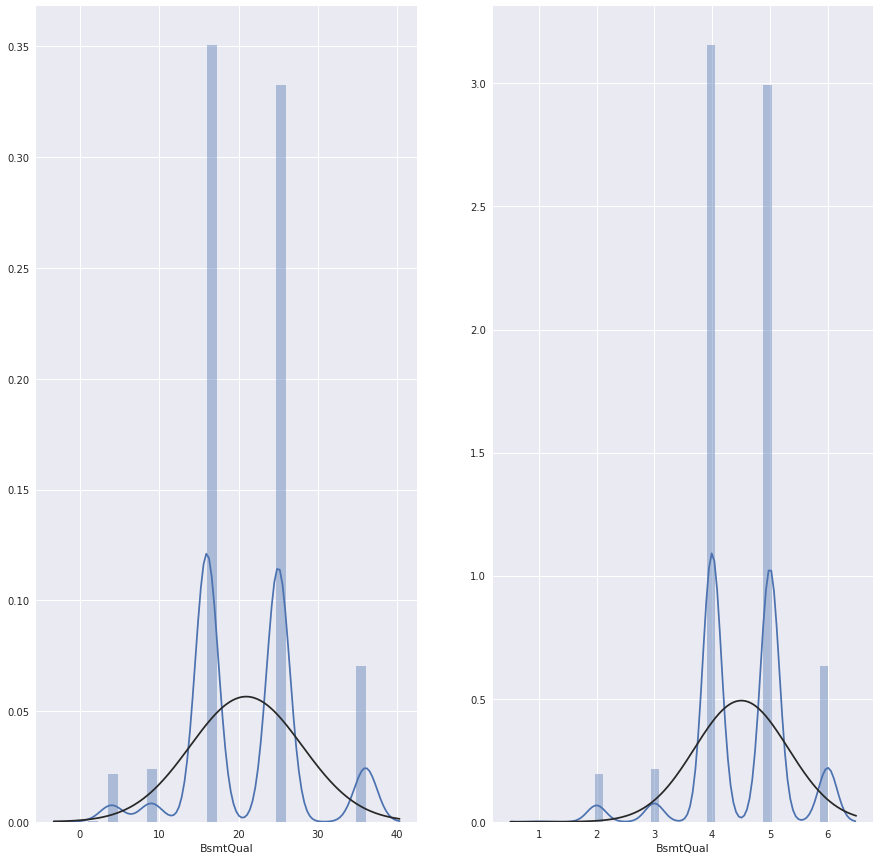

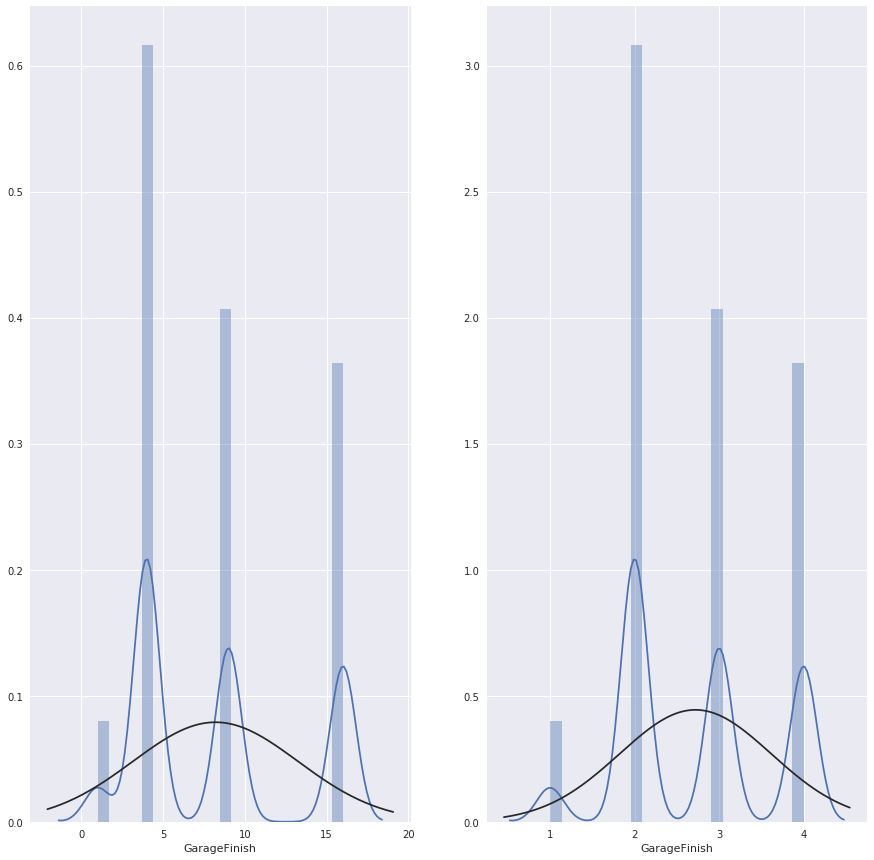

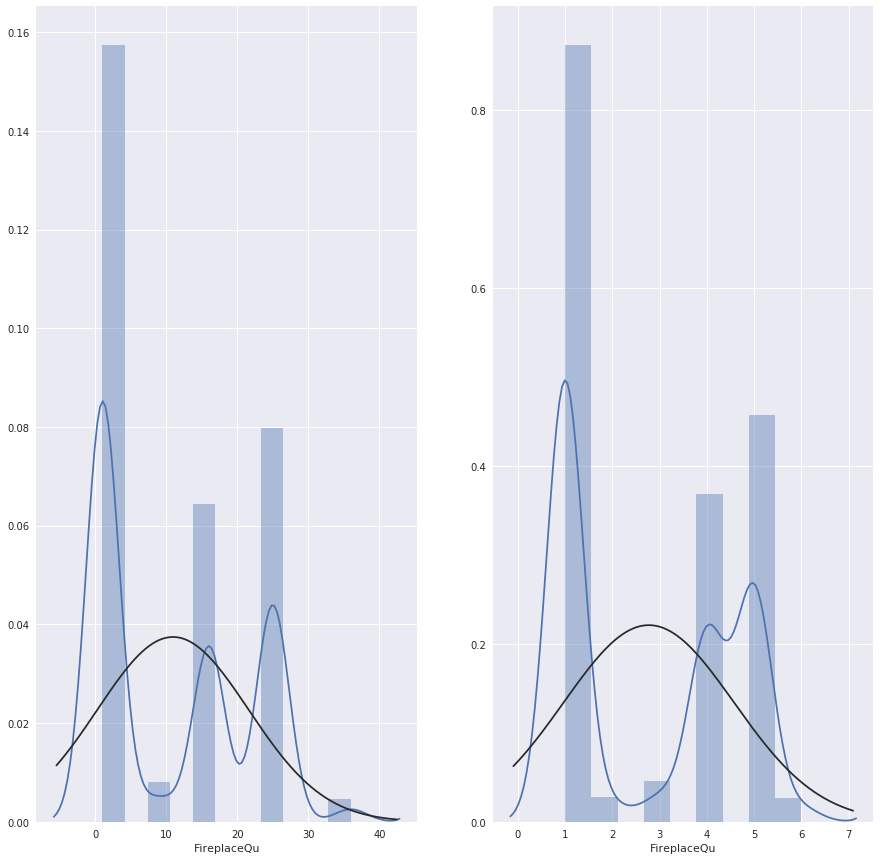

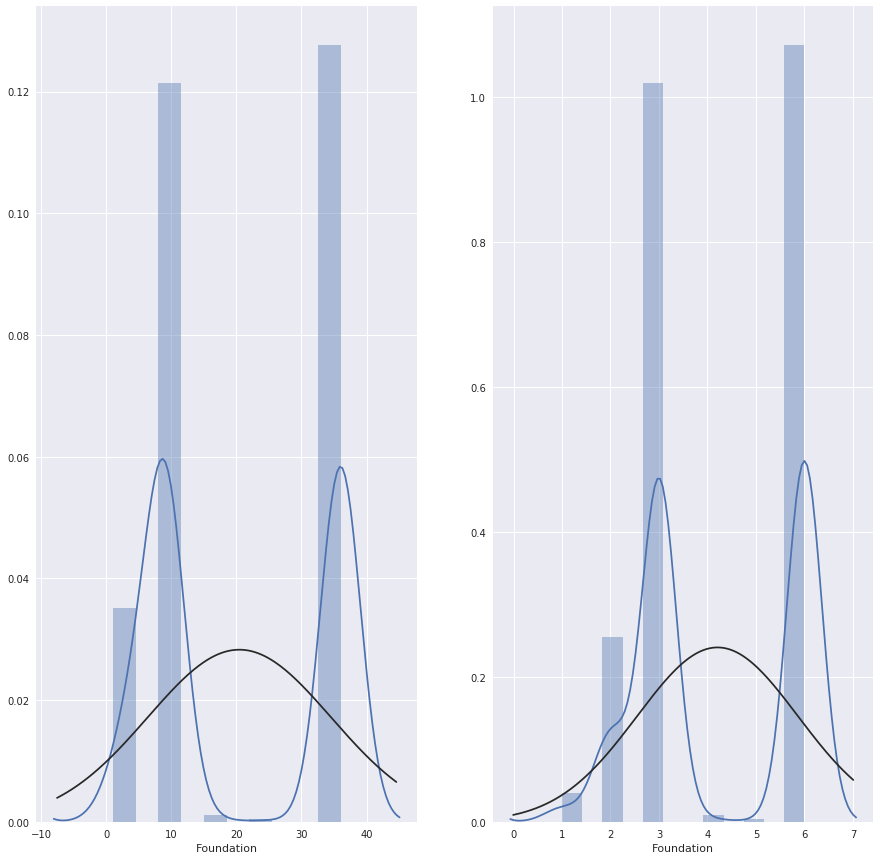

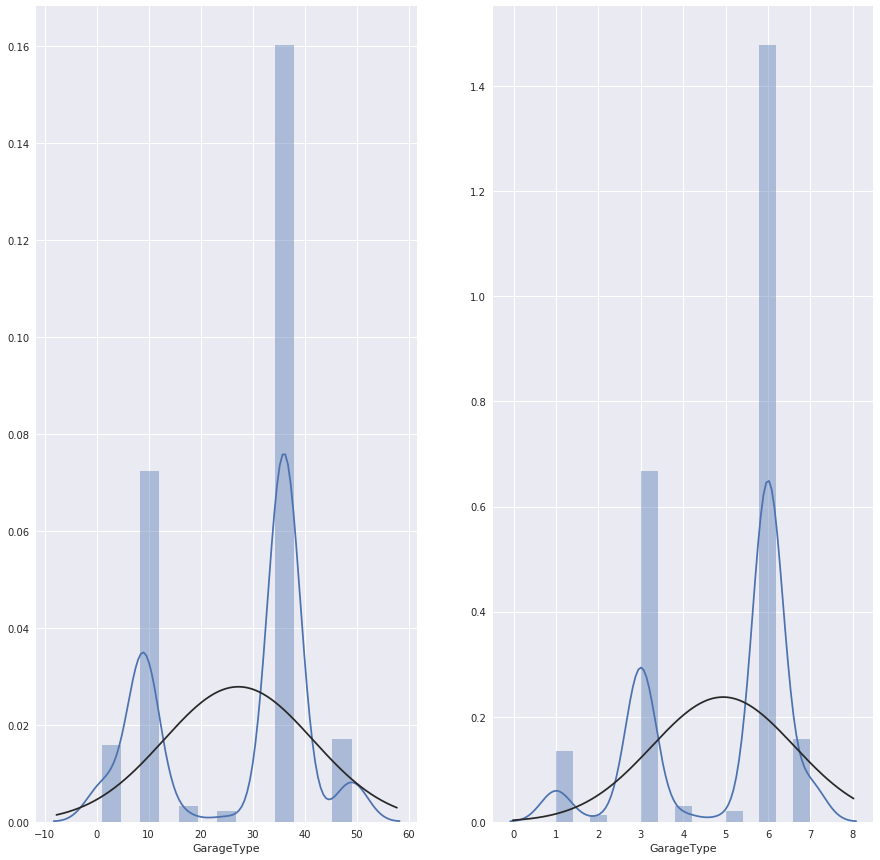

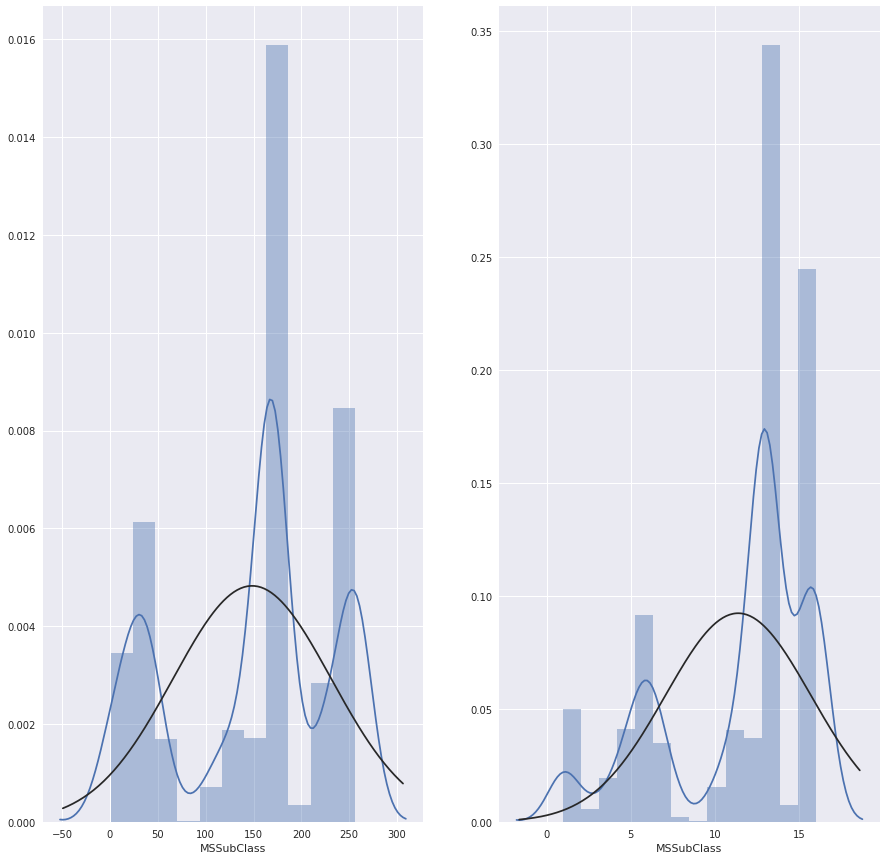

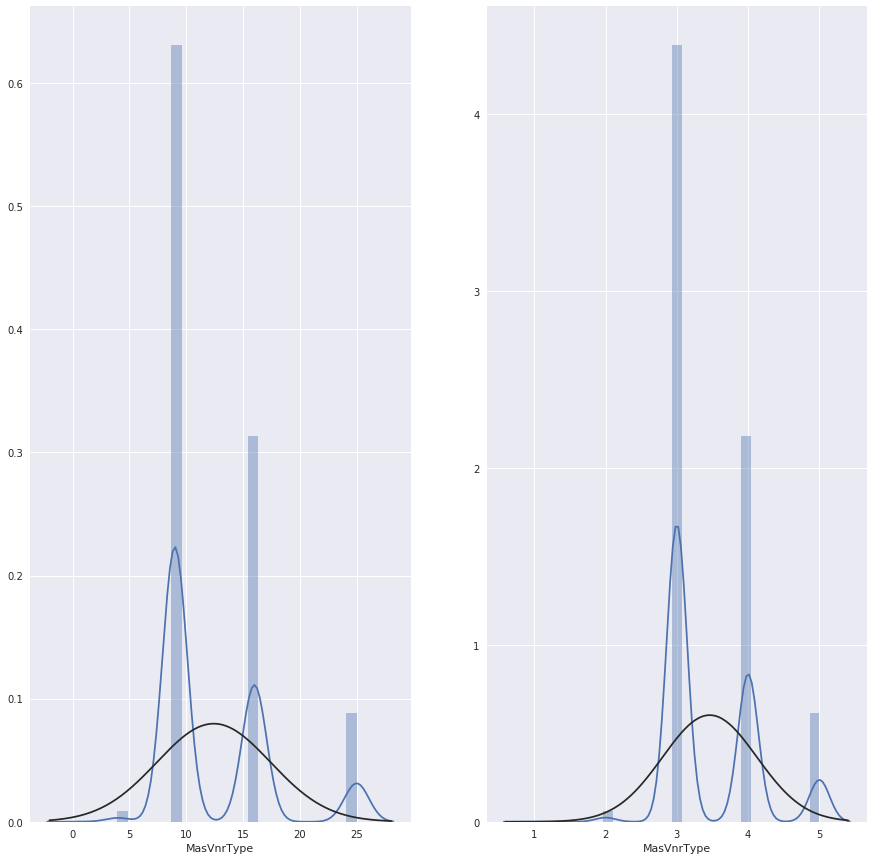

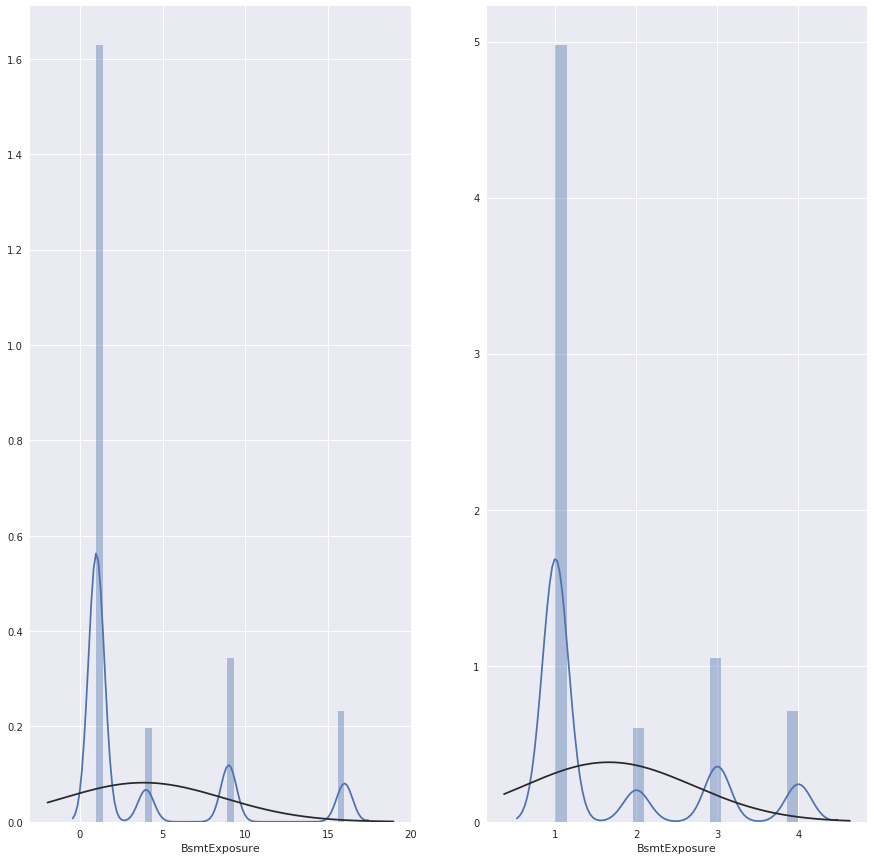

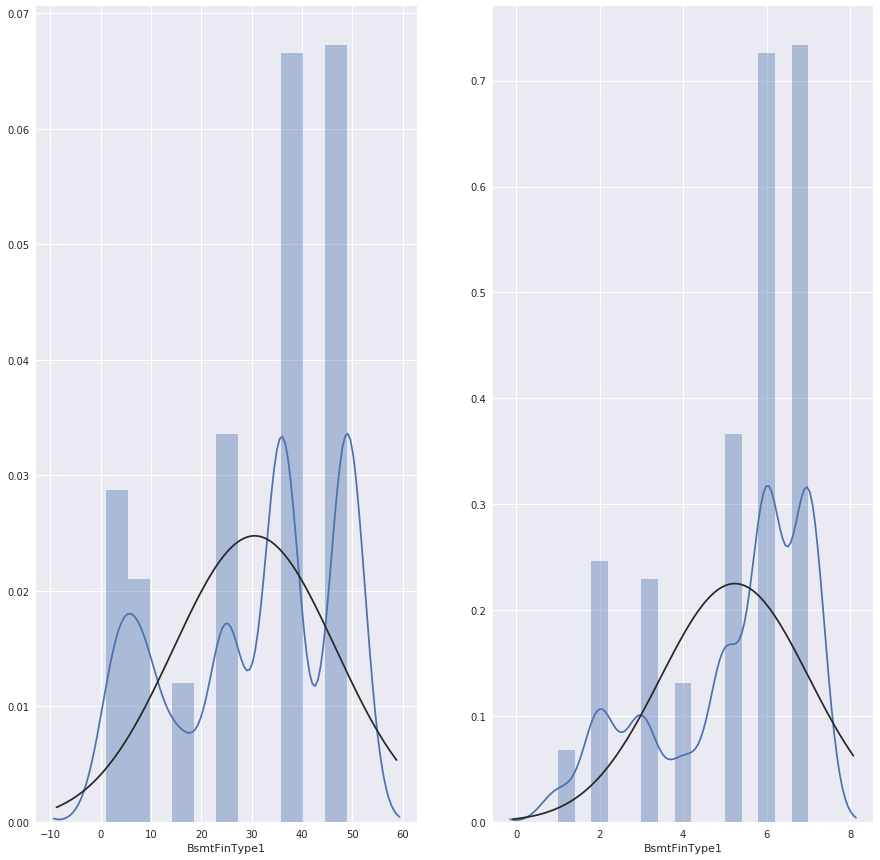

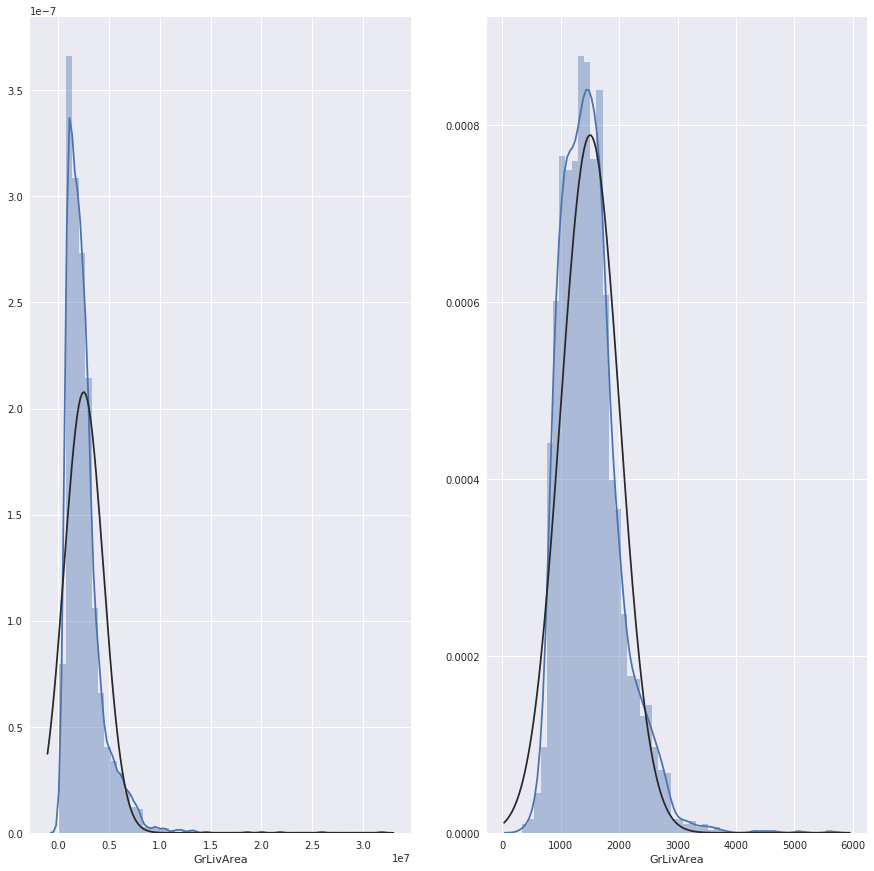

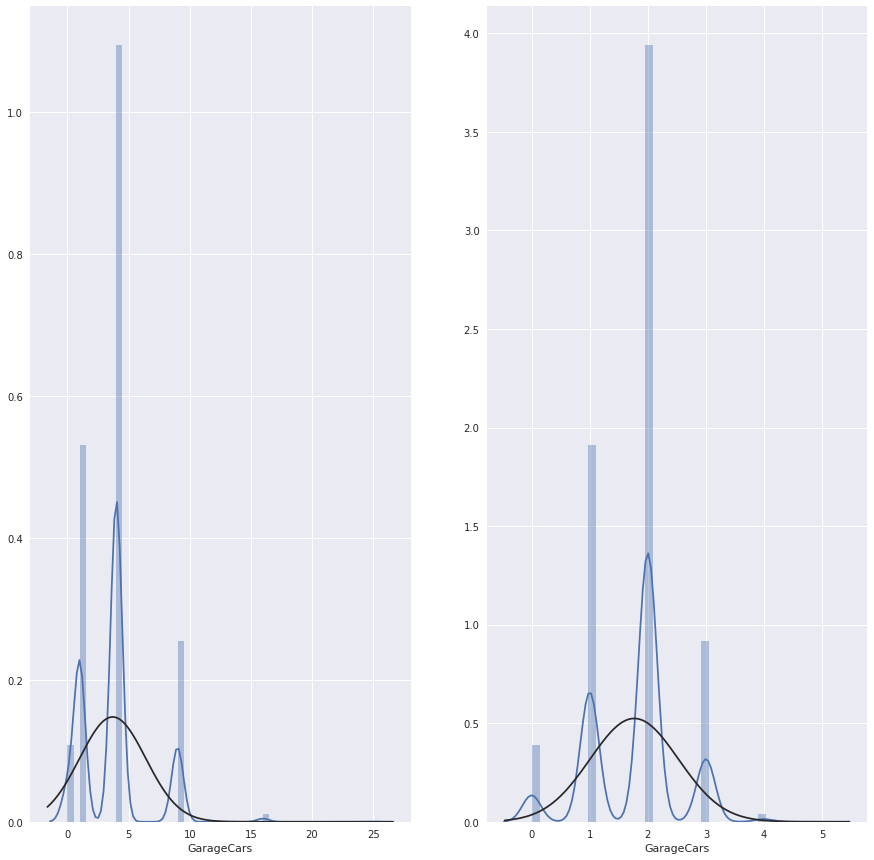

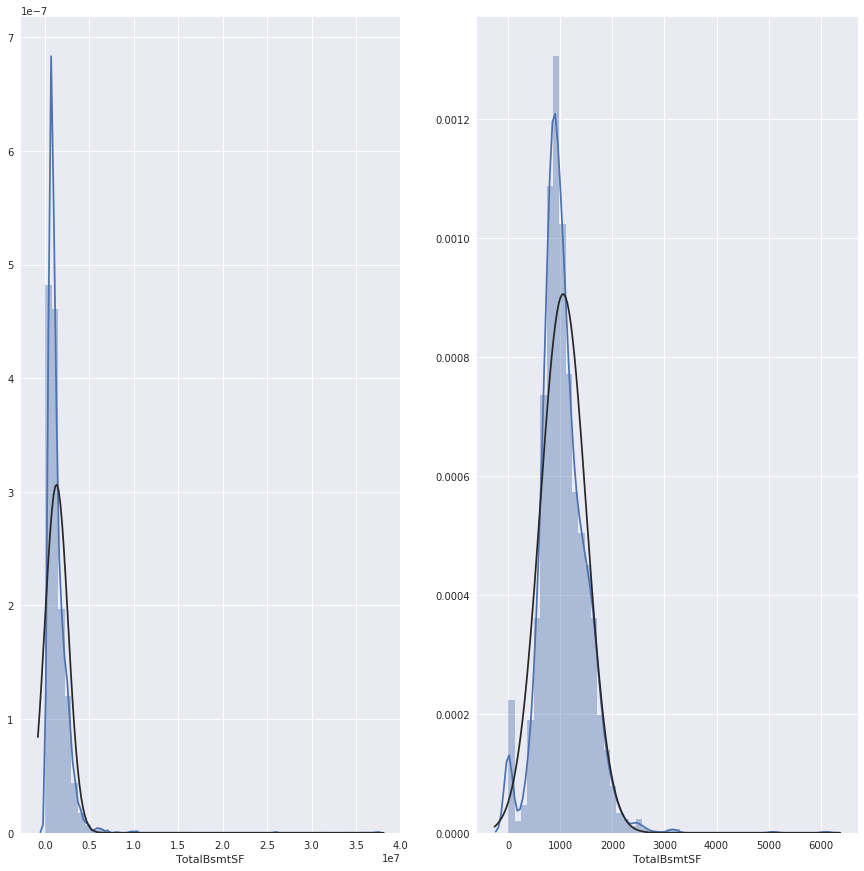

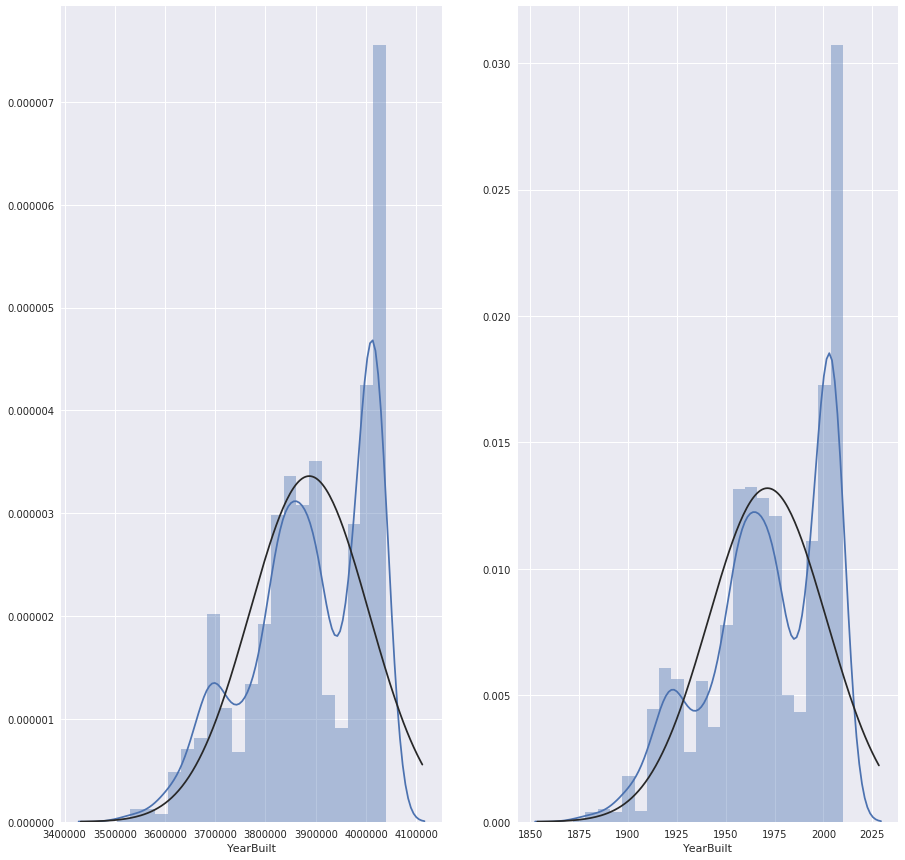

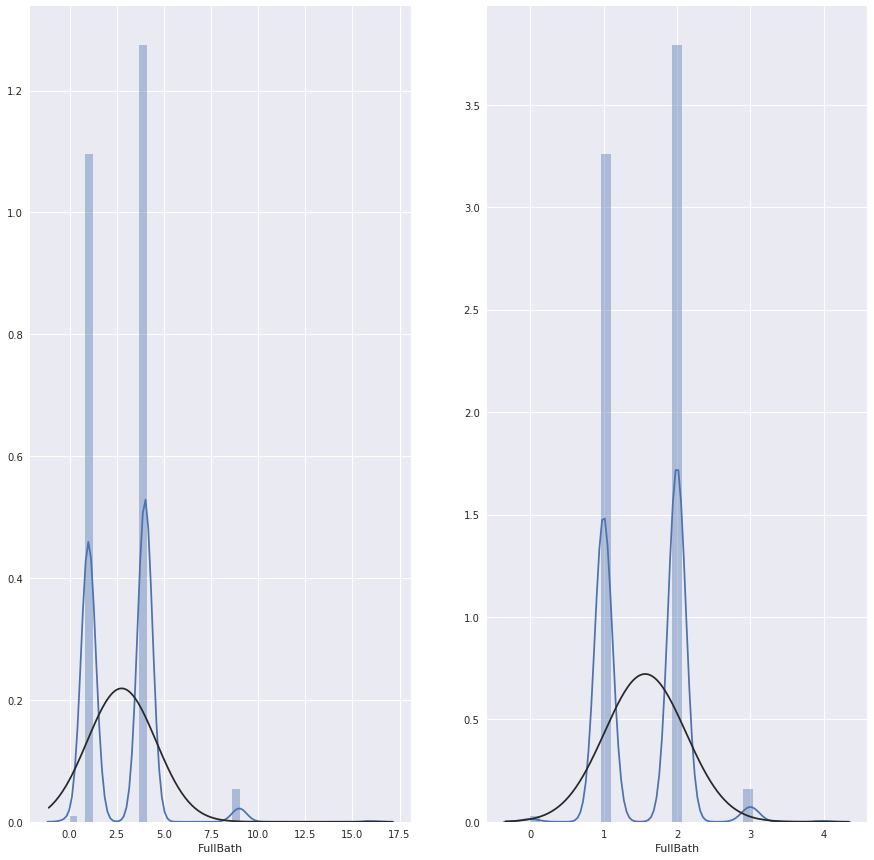

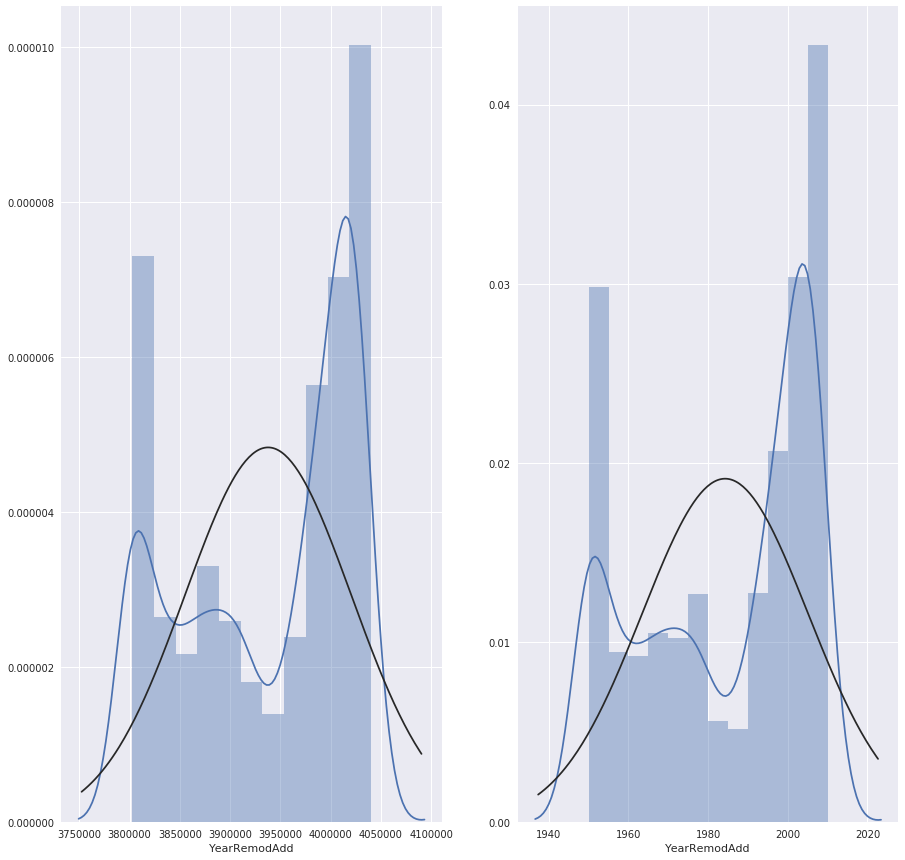

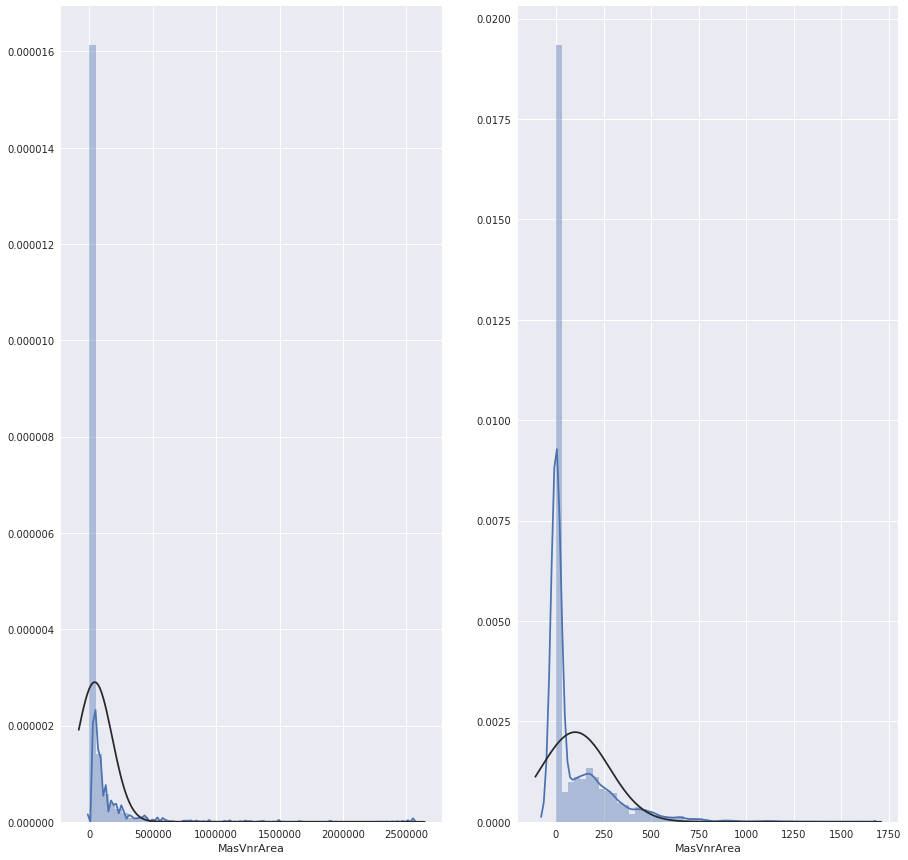

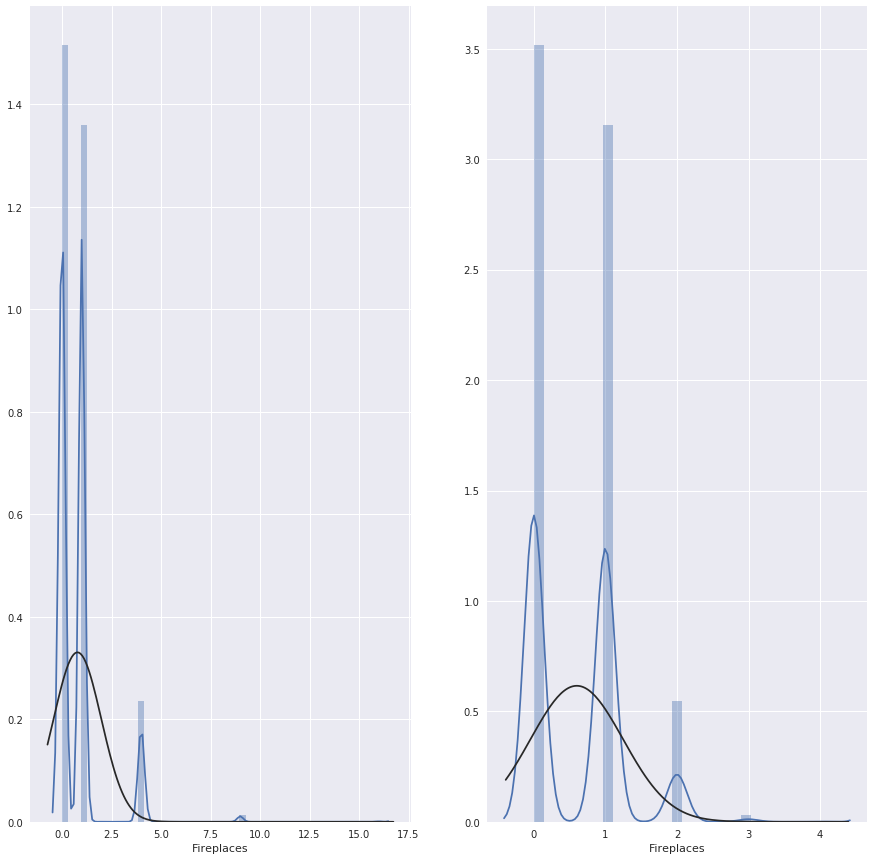

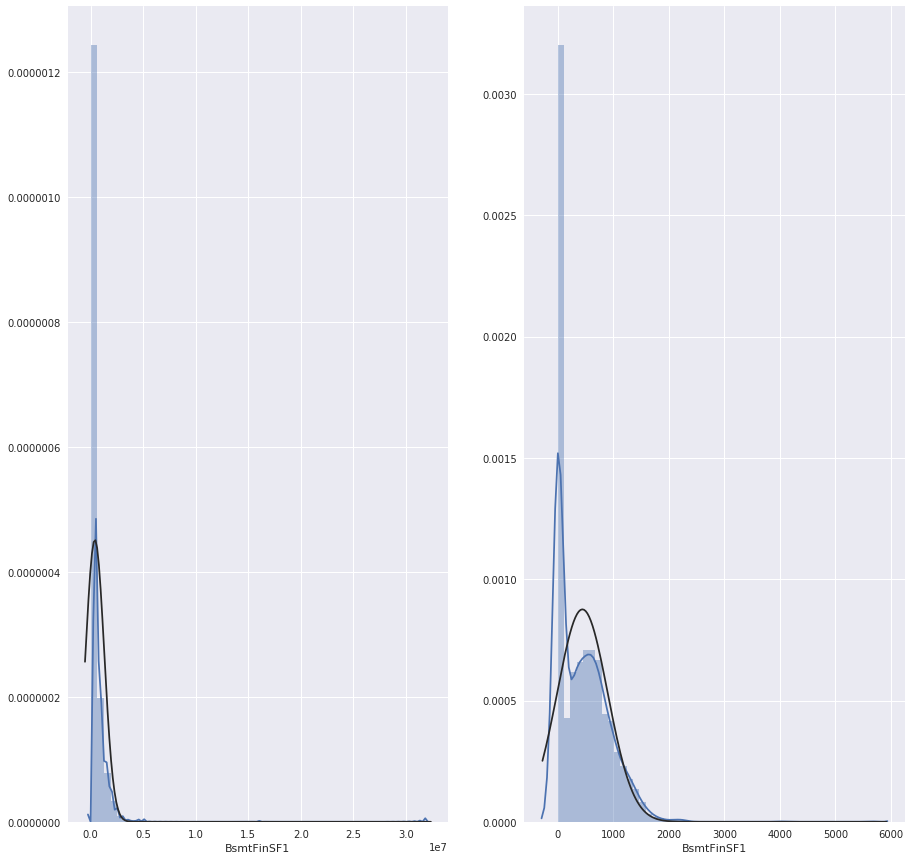

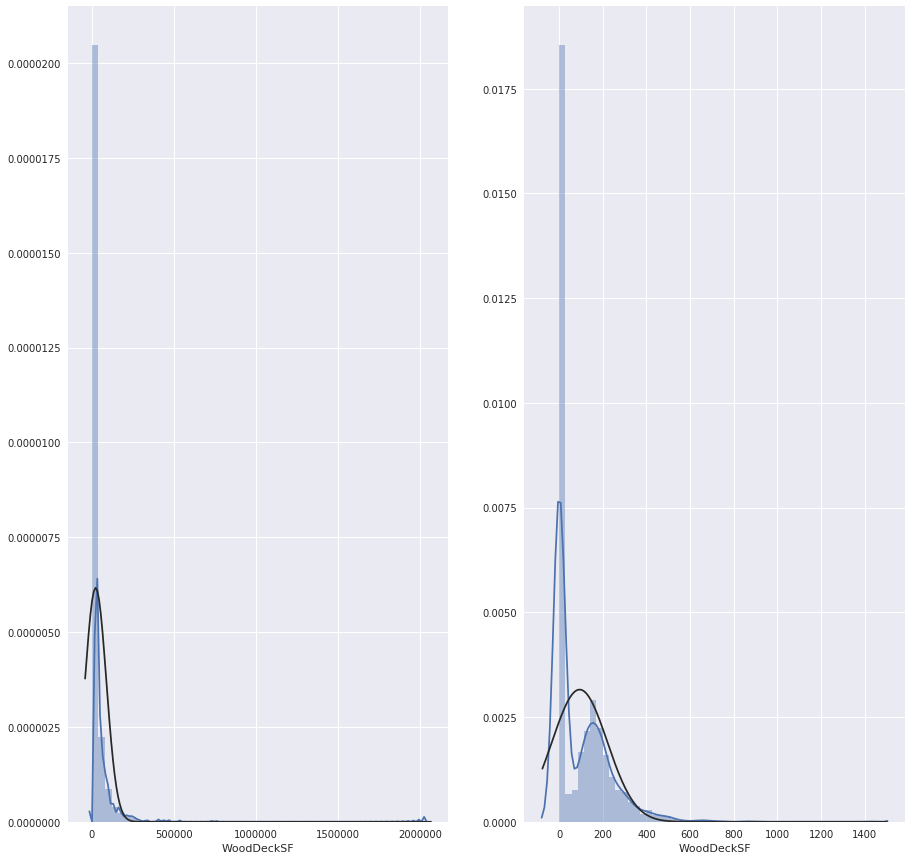

In [36]:
for feature in features:
    plt.figure()
    fig, ax =plt.subplots(1,2)
    sns.set(rc={'figure.figsize':(15,15)})
    sns.distplot(pow_frame[feature], fit=norm, ax=ax[0]);
    sns.distplot(full_frame[feature], fit=norm, ax=ax[1]);

### Save results for future learning

In [37]:
notebook_collection = db["notebook"]
notebook_collection.remove({})
notebook_collection.insert_many(full_frame.to_dict('records'))